# Visualización de los resultados del testing
- Este notebook está desarrollado con el objetivo de generar visualizaciones de los embeddings 2D generados por el sistema y gráficas con métricas temporales y de *trustworthiness*.

In [341]:
import os
import re
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [342]:
ARTIFACTS_PATH = os.path.join("..", "artifacts")

DATASET_NAMES = []
print("- Existen artifacts de los siguientes datasets:")
for dataset_name in os.listdir(ARTIFACTS_PATH):
    print(f"    - {dataset_name}")
    DATASET_NAMES.append(dataset_name)

- Existen artifacts de los siguientes datasets:
    - cifar_10_small
    - Fashion-MNIST
    - Glass-Classification
    - mnist_784


In [343]:
# Cargamos los archivos CSV que contienen los resultados y los ficheros
# .pkl que contienen los embeddings
TEST_OUTPUTS = {}
for dataset_name in os.listdir(ARTIFACTS_PATH):
    TEST_OUTPUTS[dataset_name] = {
        "embeddings": [],
        "labels": [],
        "csv": None
    }
    dataset_path = os.path.join(ARTIFACTS_PATH, dataset_name)
    for f in os.listdir(dataset_path):
        if f.endswith(".csv"):
            TEST_OUTPUTS[dataset_name]["csv"] = os.path.join(dataset_path, f)
        elif f.endswith("embeddings.pkl"):
            TEST_OUTPUTS[dataset_name]["embeddings"].append(os.path.join(dataset_path, f))
        elif f.endswith("labels.pkl"):
            TEST_OUTPUTS[dataset_name]["labels"].append(os.path.join(dataset_path, f))
        else:
            pass

In [344]:
def load_embeddings(dataset_name: str) -> list[tuple[str, tuple[np.ndarray, np.ndarray]]]:
    embeddings = []
    for e in TEST_OUTPUTS[dataset_name]["embeddings"]:
        embedding_name = re.sub(re.escape(dataset_name), "", e, flags=re.IGNORECASE)
        embedding_name = "-".join(embedding_name.split('-')[1:-1])
        with open(e, "rb") as f:
            embedding_dict = pickle.load(f)
            embedding_train = embedding_dict["embedding_train"]
            embedding_test = embedding_dict["embedding_test"]
        embeddings.append((embedding_name, (embedding_train, embedding_test)))
    return embeddings

def load_labels(dataset_name: str) -> list[tuple[str, tuple[np.ndarray, np.ndarray]]]:
    labels = []
    for l in TEST_OUTPUTS[dataset_name]["labels"]:
        labels_name = re.sub(re.escape(dataset_name), "", l, flags=re.IGNORECASE)
        labels_name = " ".join(labels_name.split('-')[1:-1])
        with open(l, "rb") as f:
            labels_dict = pickle.load(f)
            labels_train = labels_dict["labels_train"]
            labels_test = labels_dict["labels_test"]
        labels.append((labels_name, (labels_train, labels_test)))
    return labels

def load_timings(dataset_name: str) -> list[tuple[str, tuple[float, float, float]]]:
    timings = []
    df = pd.read_csv(TEST_OUTPUTS[dataset_name]["csv"])
    for rc in df.to_dict(orient="records"):
        timing_name = rc.get("test_id")
        elapsed_fit_train = rc.get("elapsed_fit_train")
        elapsed_transform_train = rc.get("elapsed_transform_train")
        elapsed_transform_test = rc.get("elapsed_transform_test")
        timings.append((timing_name, (elapsed_fit_train, elapsed_transform_train, elapsed_transform_test)))
    return timings

def load_trustworthiness(dataset_name: str) -> list[tuple[str, tuple[float, float]]]:
    trustworthiness = []
    df = pd.read_csv(TEST_OUTPUTS[dataset_name]["csv"])
    for rc in df.to_dict(orient="records"):
        metric_name = rc.get("test_id")
        trustworthiness_train = rc.get("trustworthiness_train")
        trustworthiness_test = rc.get("trustworthiness_test")
        trustworthiness.append((metric_name, (trustworthiness_train, trustworthiness_test)))
    return trustworthiness

def plot_embeddings(embeddings: list[tuple[str, np.ndarray]], labels: list[tuple[str, tuple[np.ndarray, np.ndarray]]], subset: str = "train", save_fig: bool = True, name: str = "plot.png") -> None:
    if subset == "train":
        subset_idx = 0
    elif subset == "test":
        subset_idx = 1
    else:
        raise ValueError(f"subset debe ser train o test, no {subset}")

    n_embeddings = len(embeddings)
    n_cols = int(np.ceil(np.sqrt(n_embeddings)))
    n_rows = int(np.ceil(n_embeddings / n_cols))
    while n_rows >= n_cols:
        n_cols += 1
        n_rows = int(np.ceil(n_embeddings / n_cols))

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*4))
    fig.subplots_adjust(wspace=0.6, hspace=0.4, right=0.90)

    embedding_idx = 0
    for row in range(len(axs)):
        for col in range(len(axs[0, :])):
            embedding_name, embedding = embeddings[embedding_idx]
            _, label = labels[embedding_idx]

            axs[row, col].set_title(embedding_name)
            axs[row, col].axis("off")
            sc = axs[row, col].scatter(embedding[subset_idx][:, 0], embedding[subset_idx][:, 1], c=label[subset_idx], cmap="viridis")

            embedding_idx += 1
    
    cbar = fig.colorbar(sc, ax=axs, orientation="vertical")
    cbar.set_label("label")

    if save_fig:
        plt.savefig(name) 
    plt.show()

def plot_timings(timings: list[tuple[str, tuple[float, float, float]]], save_fig: bool = True, name: str = "plot.png") -> None:
    n_timings = len(timings)
    n_cols = int(np.ceil(np.sqrt(n_timings)))
    n_rows = int(np.ceil(n_timings / n_cols))
    while n_rows >= n_cols:
        n_cols += 1
        n_rows = int(np.ceil(n_timings / n_cols))

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*4))
    fig.subplots_adjust(wspace=0.6, hspace=0.4, right=0.90)

    timing_idx = 0
    colors = ["blue", "orange", "green"]
    measurements = ["fit_train", "transform_train", "transform_test"]
    for row in range(len(axs)):
        for col in range(len(axs[0, :])):
            timing_name, (elapsed_fit_train, elapsed_transform_train, elapsed_transform_test) = timings[timing_idx]

            axs[row, col].set_title(timing_name)
            axs[row, col].axis("on")
            bars = axs[row, col].bar(
                measurements,
                [elapsed_fit_train, elapsed_transform_train, elapsed_transform_test],
                color=colors
            )
            axs[row, col].set_ylabel("Tiempo (segundos)")
            axs[row, col].set_xticks(range(len(measurements)))
            axs[row, col].set_xticklabels(measurements)

            timing_idx += 1

    if save_fig:
        plt.savefig(name) 
    plt.show()

def plot_trustworthiness(trustworthiness: list[tuple[str, tuple[float, float]]], save_fig: bool = True, name: str = "plot.png") -> None:
    n_metrics = len(trustworthiness)
    n_cols = int(np.ceil(np.sqrt(n_metrics)))
    n_rows = int(np.ceil(n_metrics / n_cols))
    while n_rows >= n_cols:
        n_cols += 1
        n_rows = int(np.ceil(n_metrics / n_cols))

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*4))
    fig.subplots_adjust(wspace=0.6, hspace=0.4, right=0.90)

    metric_idx = 0
    for row in range(len(axs)):
        for col in range(len(axs[0, :])):
            metric_name, (trustworthiness_train, trustworthiness_test) = trustworthiness[metric_idx]

            axs[row, col].set_title(metric_name)
            axs[row, col].axis("on")
            bars = axs[row, col].bar(
                ["train", "test"],
                [trustworthiness_train, trustworthiness_test],
                color=["blue", "orange"]
            )
            axs[row, col].set_ylabel("Trustworthiness")
            axs[row, col].set_xticks([0, 1])
            axs[row, col].set_xticklabels(["train", "test"])

            metric_idx += 1

    if save_fig:
        plt.savefig(name) 
    plt.show()

Visualización de MNIST
---
### Embeddings en MNIST
---

In [345]:
mnist_embeddings = load_embeddings("mnist_784")
mnist_labels = load_labels("mnist_784")

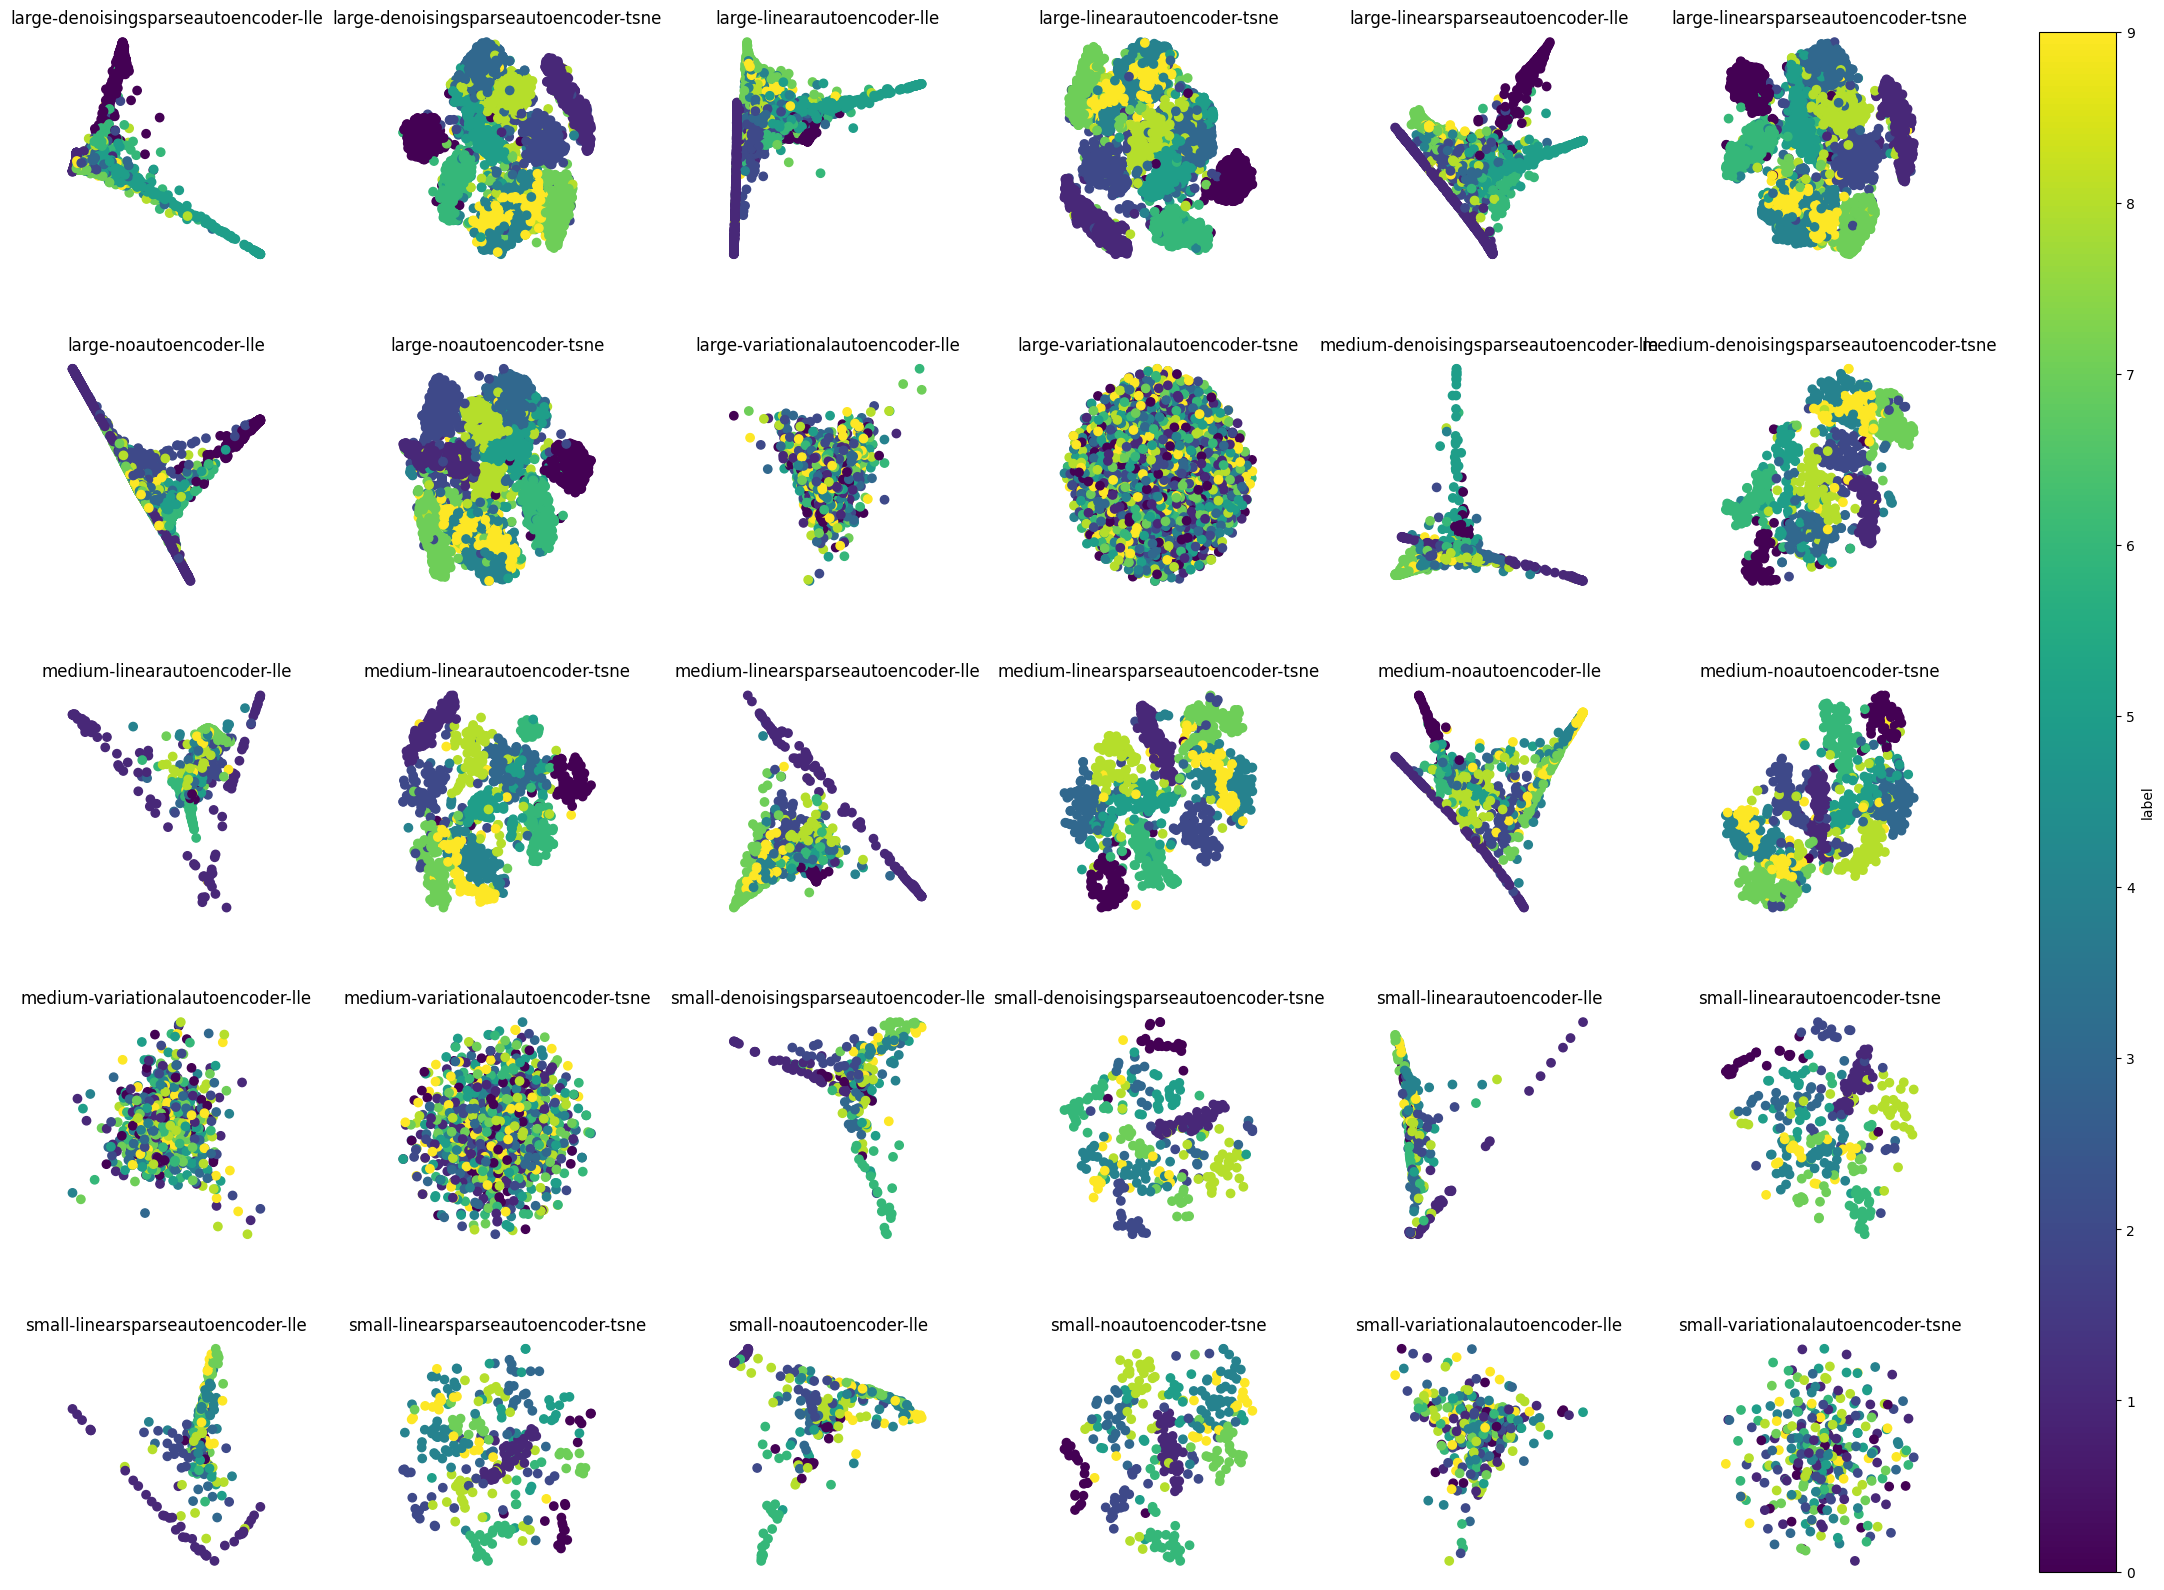

In [346]:
plot_embeddings(mnist_embeddings, mnist_labels, "train", True, "mnist_embeddings_train.png")

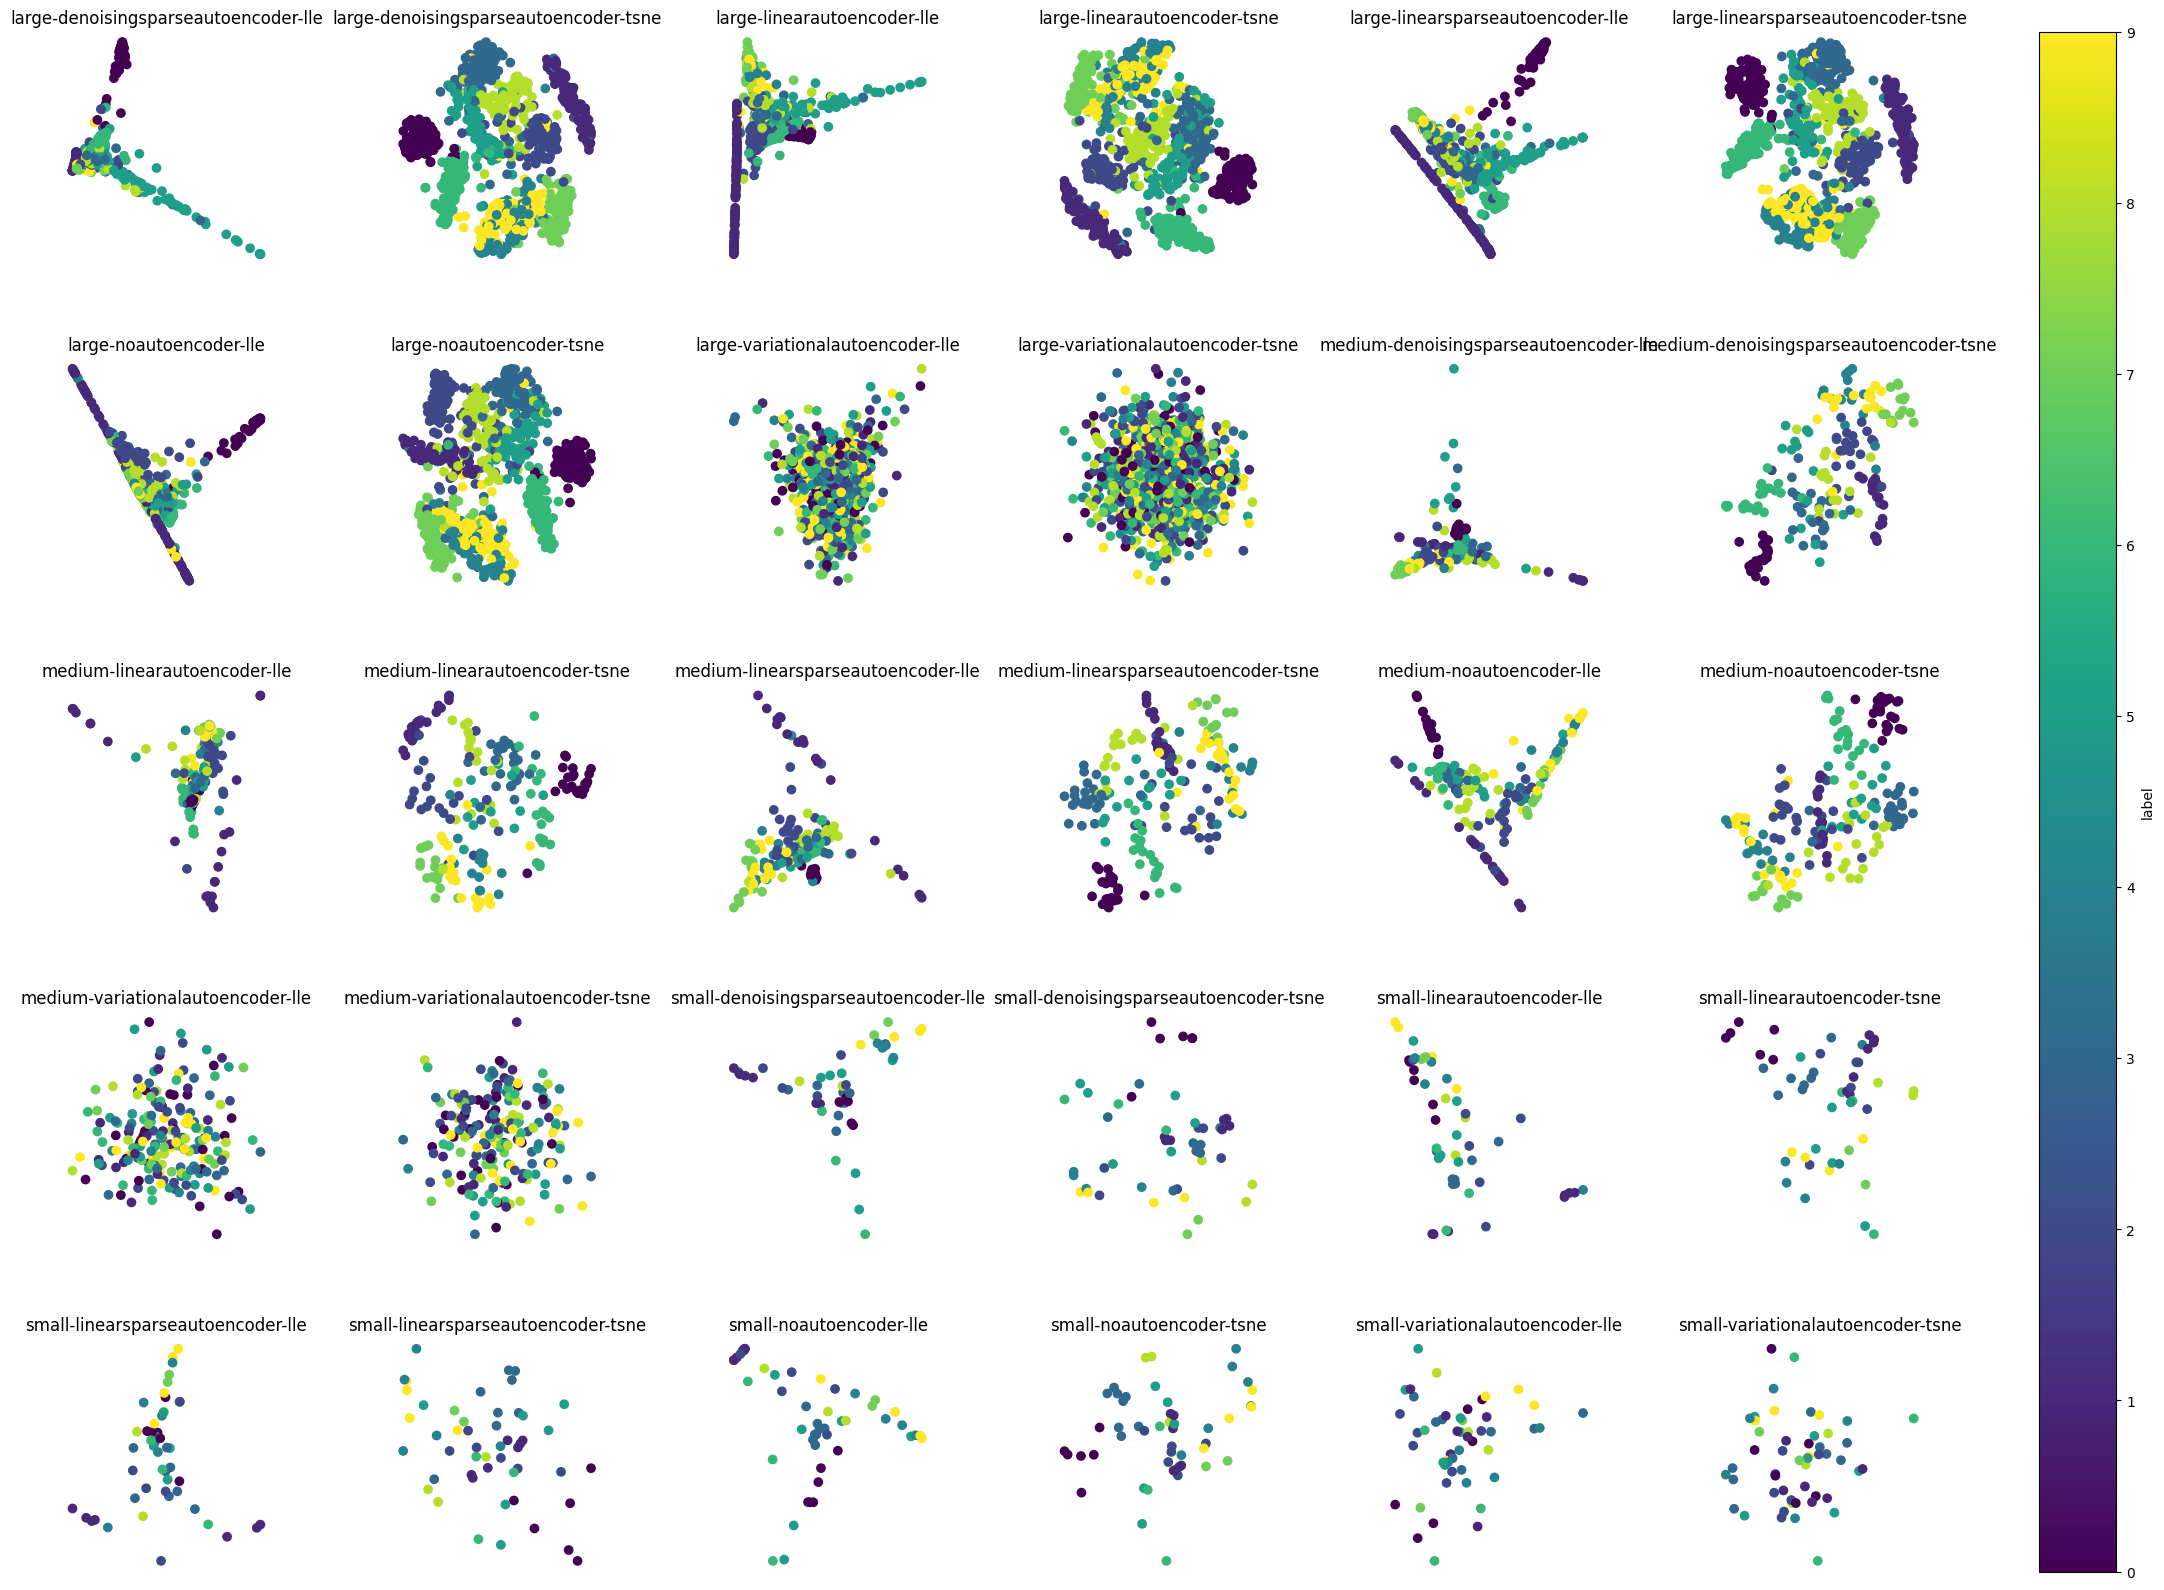

In [347]:
plot_embeddings(mnist_embeddings, mnist_labels, "test", True, "mnist_embeddings_test.png")

### Métricas temporales en MNIST
---

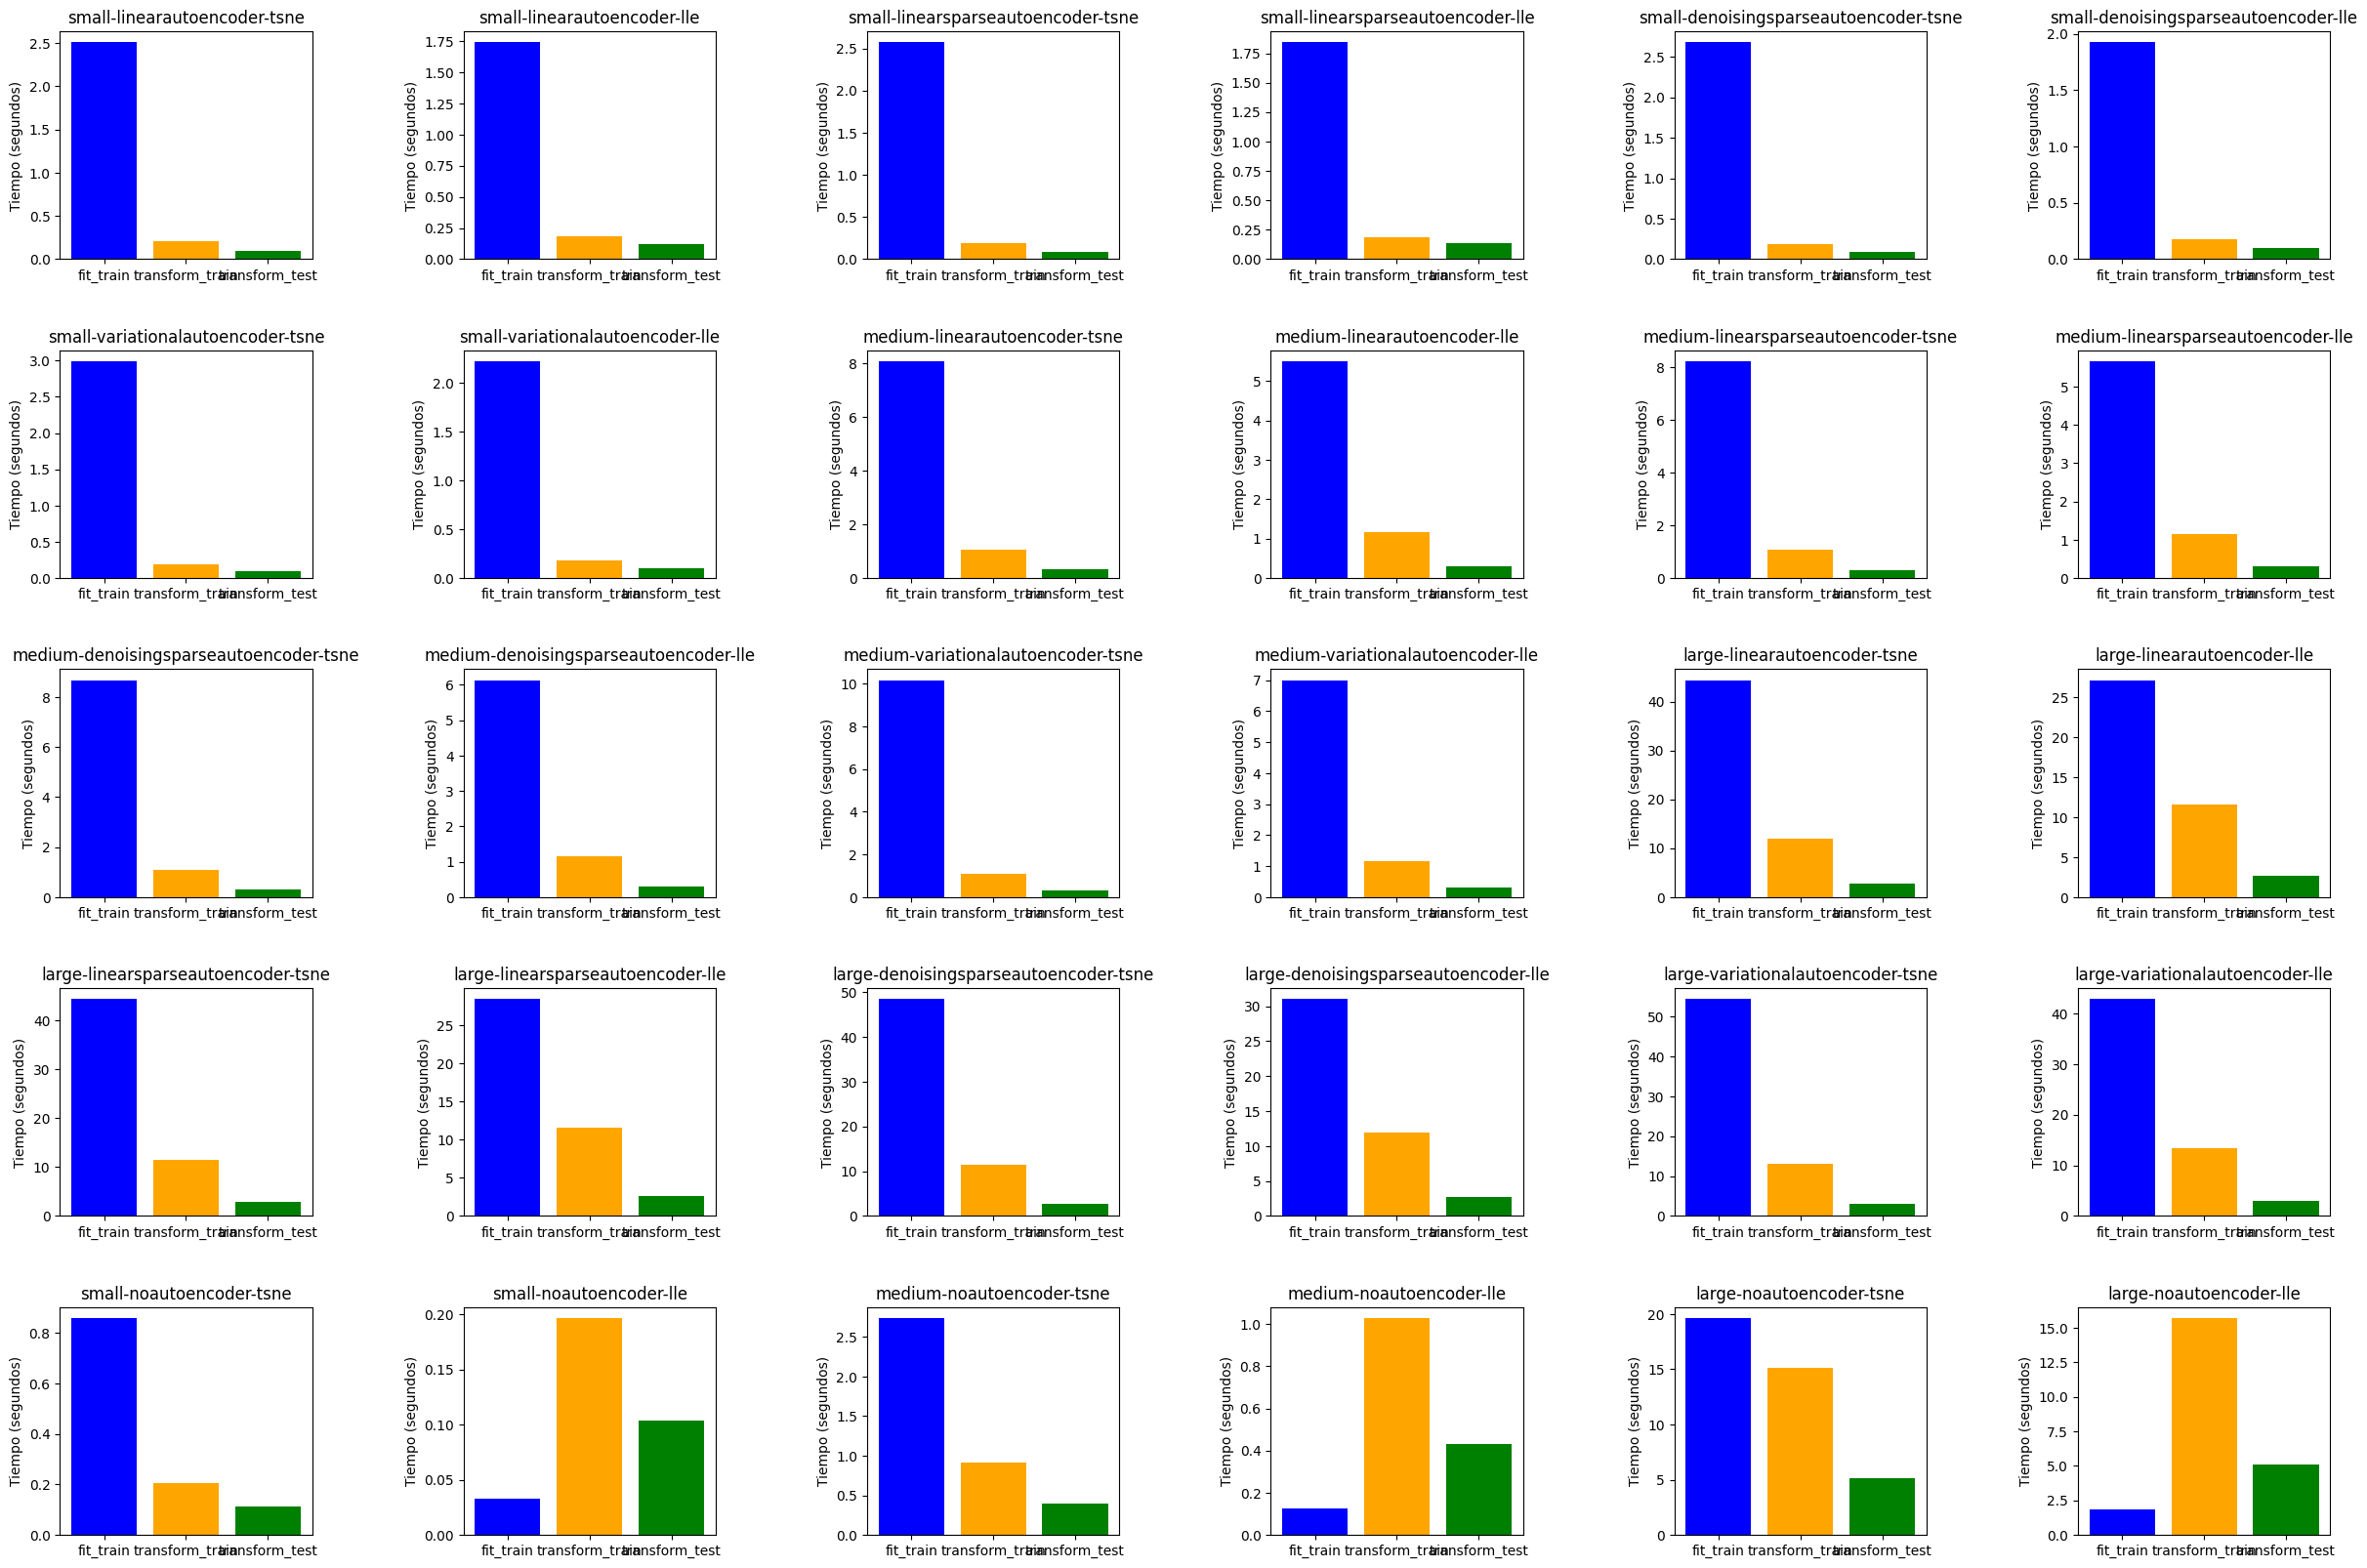

In [348]:
mnist_timings = load_timings("mnist_784")
plot_timings(mnist_timings, True, "mnist_timings.png")

### Trustworthiness en MNIST
---

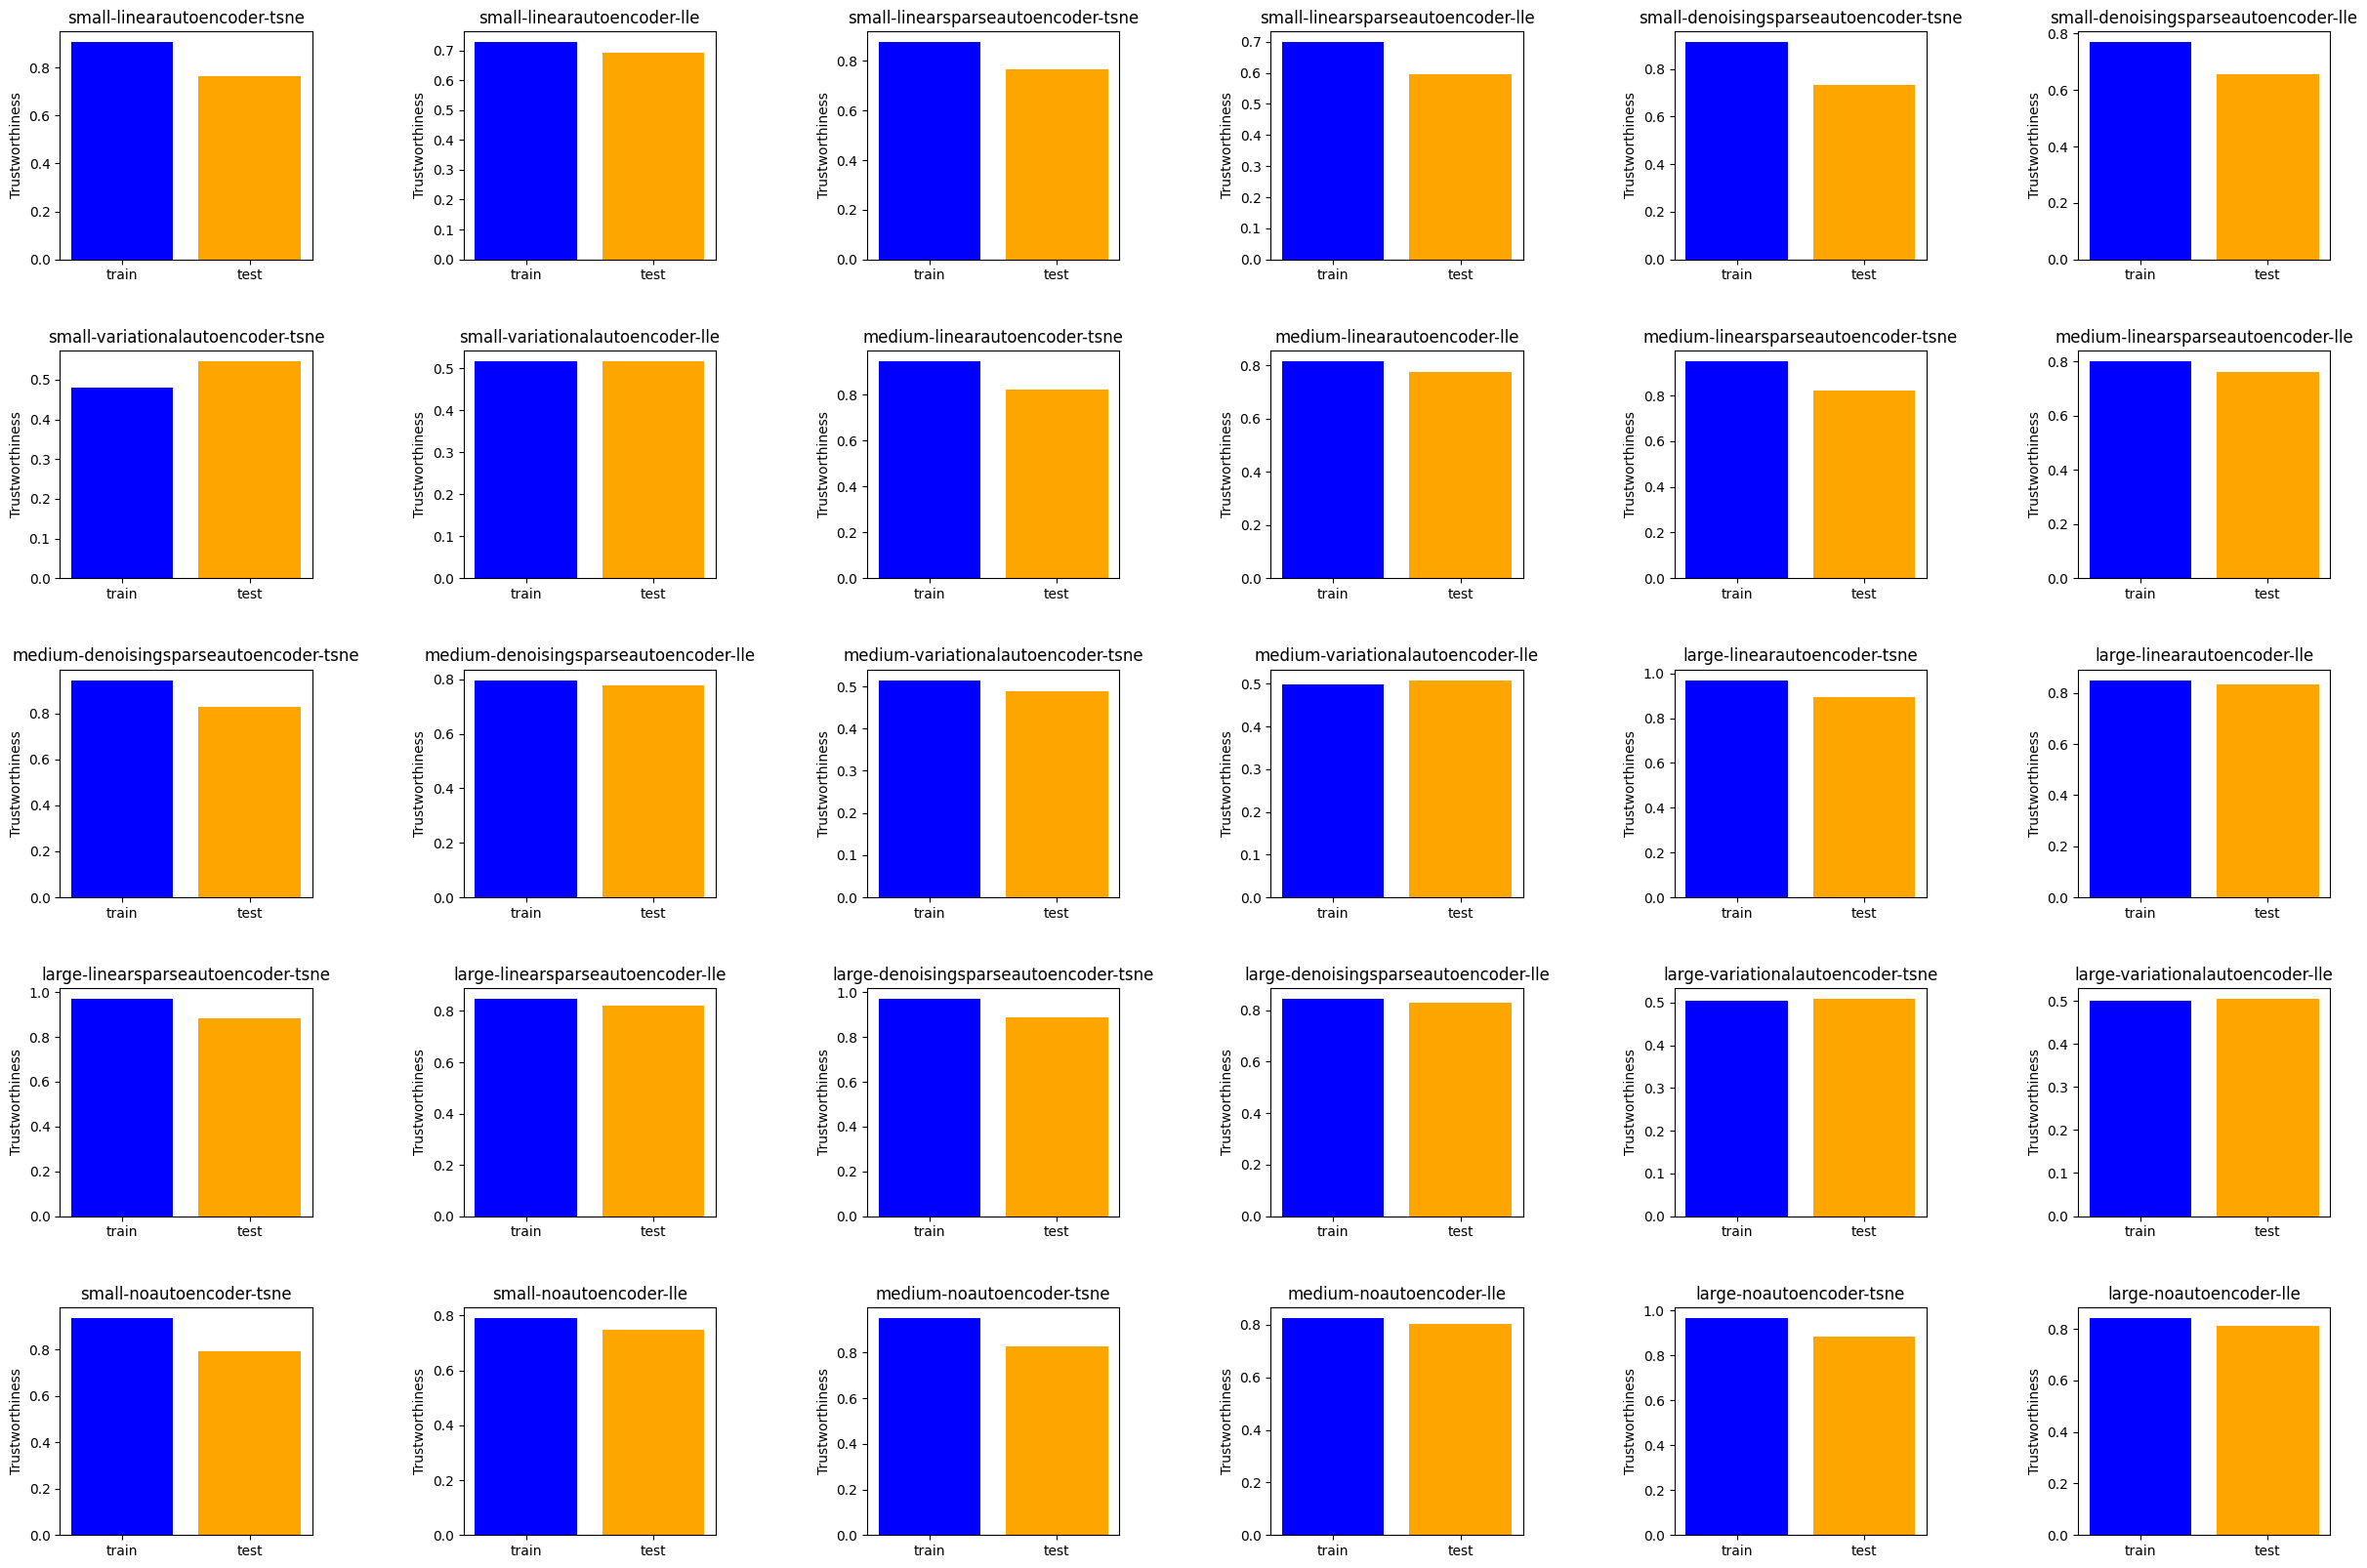

In [349]:
mnist_trustworthiness = load_trustworthiness("mnist_784")
plot_trustworthiness(mnist_trustworthiness, True, "mnist_trustworthiness.png")

Fashion MNIST
---
### Embeddings en Fashion MNIST

In [350]:
fmnist_embeddings = load_embeddings("Fashion-MNIST")
fmnist_labels = load_labels("Fashion-MNIST")

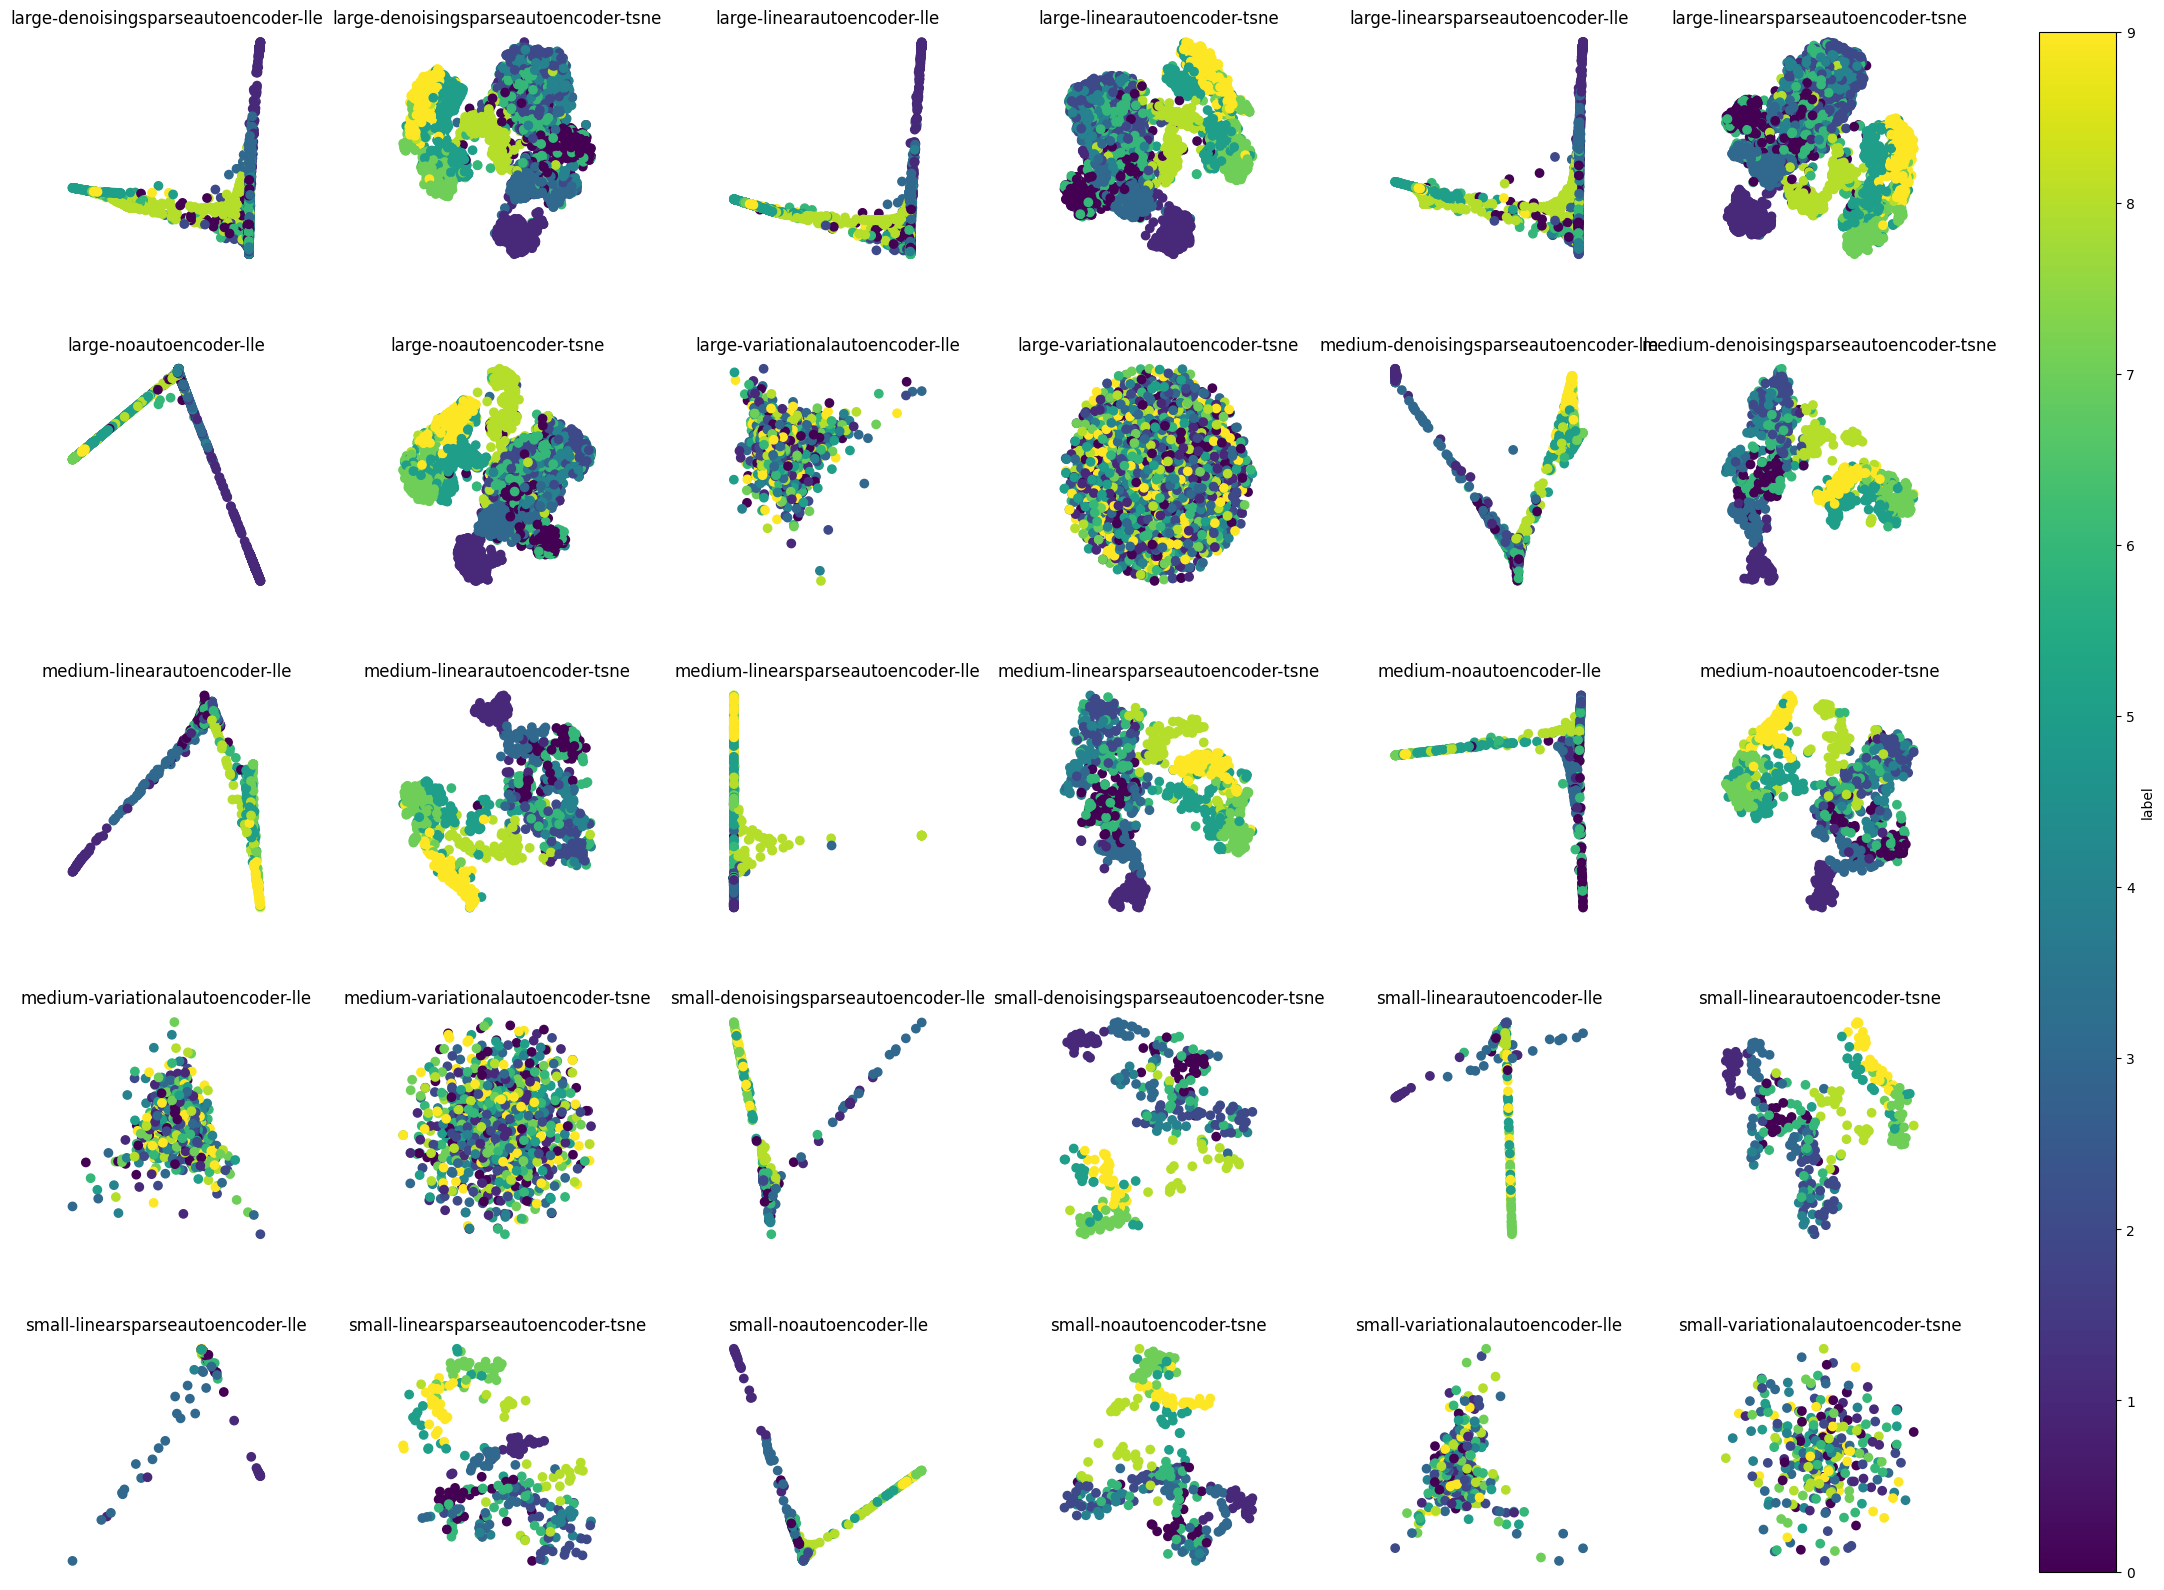

In [351]:
plot_embeddings(fmnist_embeddings, fmnist_labels, "train", True, "fmnist_embeddings_train.png")

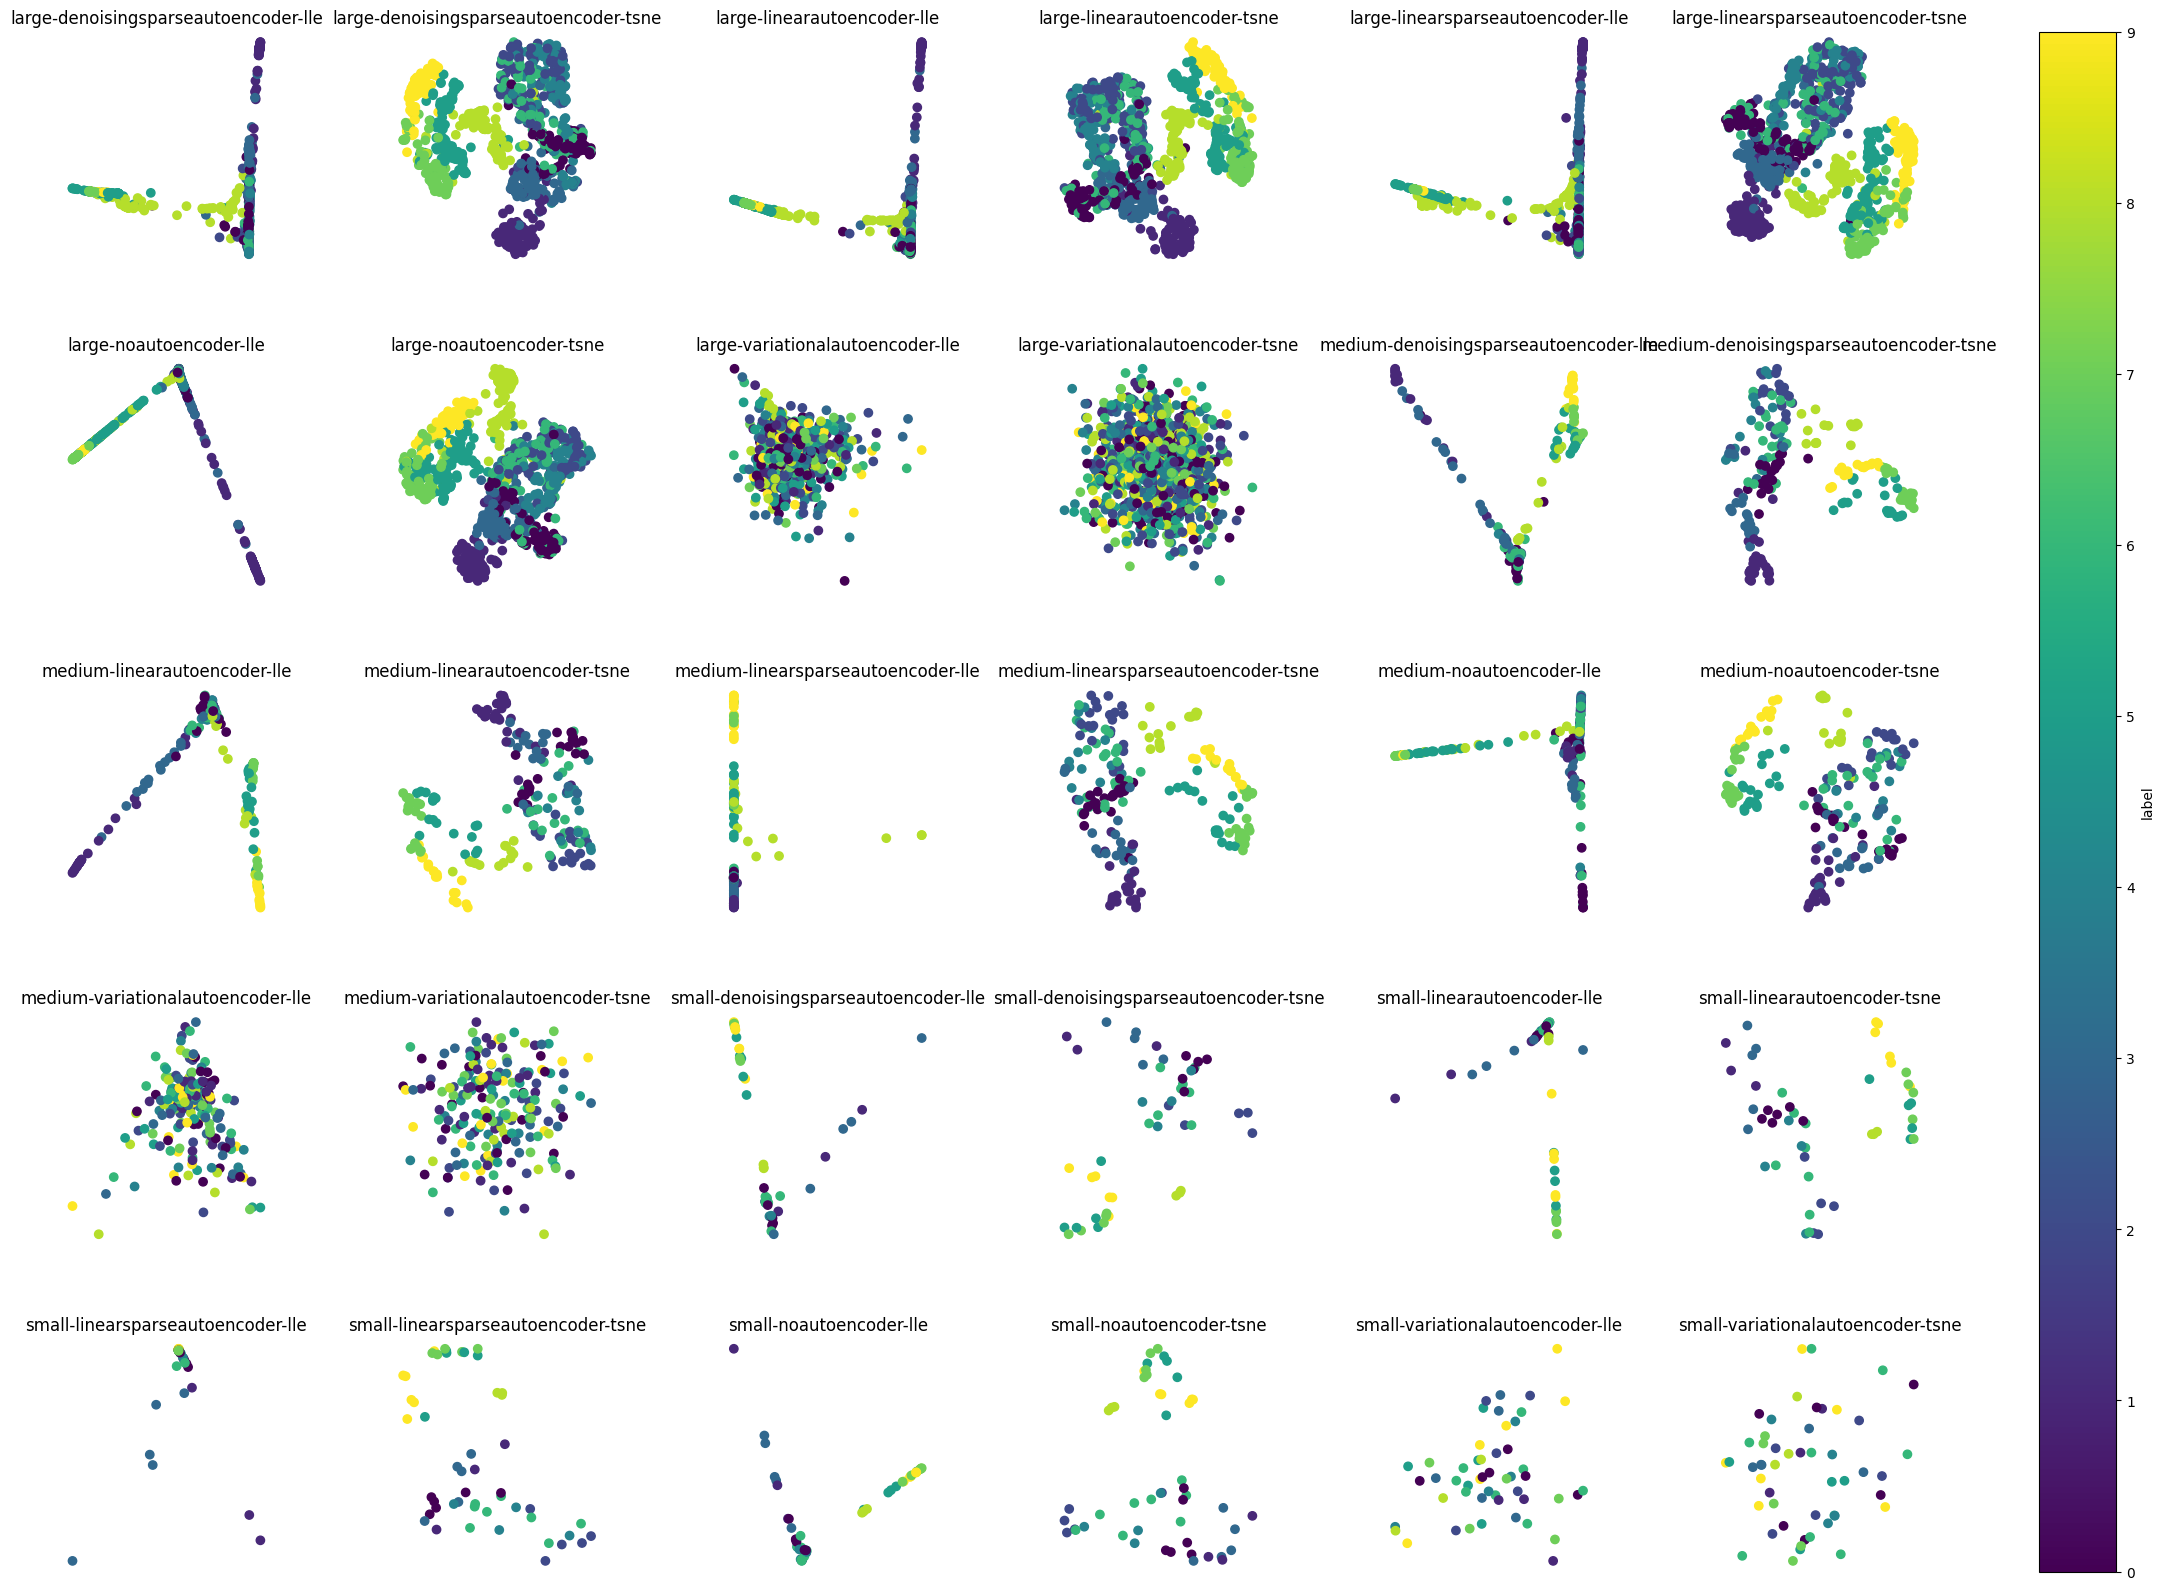

In [352]:
plot_embeddings(fmnist_embeddings, fmnist_labels, "test", True, "fmnist_embeddings_test.png")

### Métricas temporales en Fashion MNIST
---

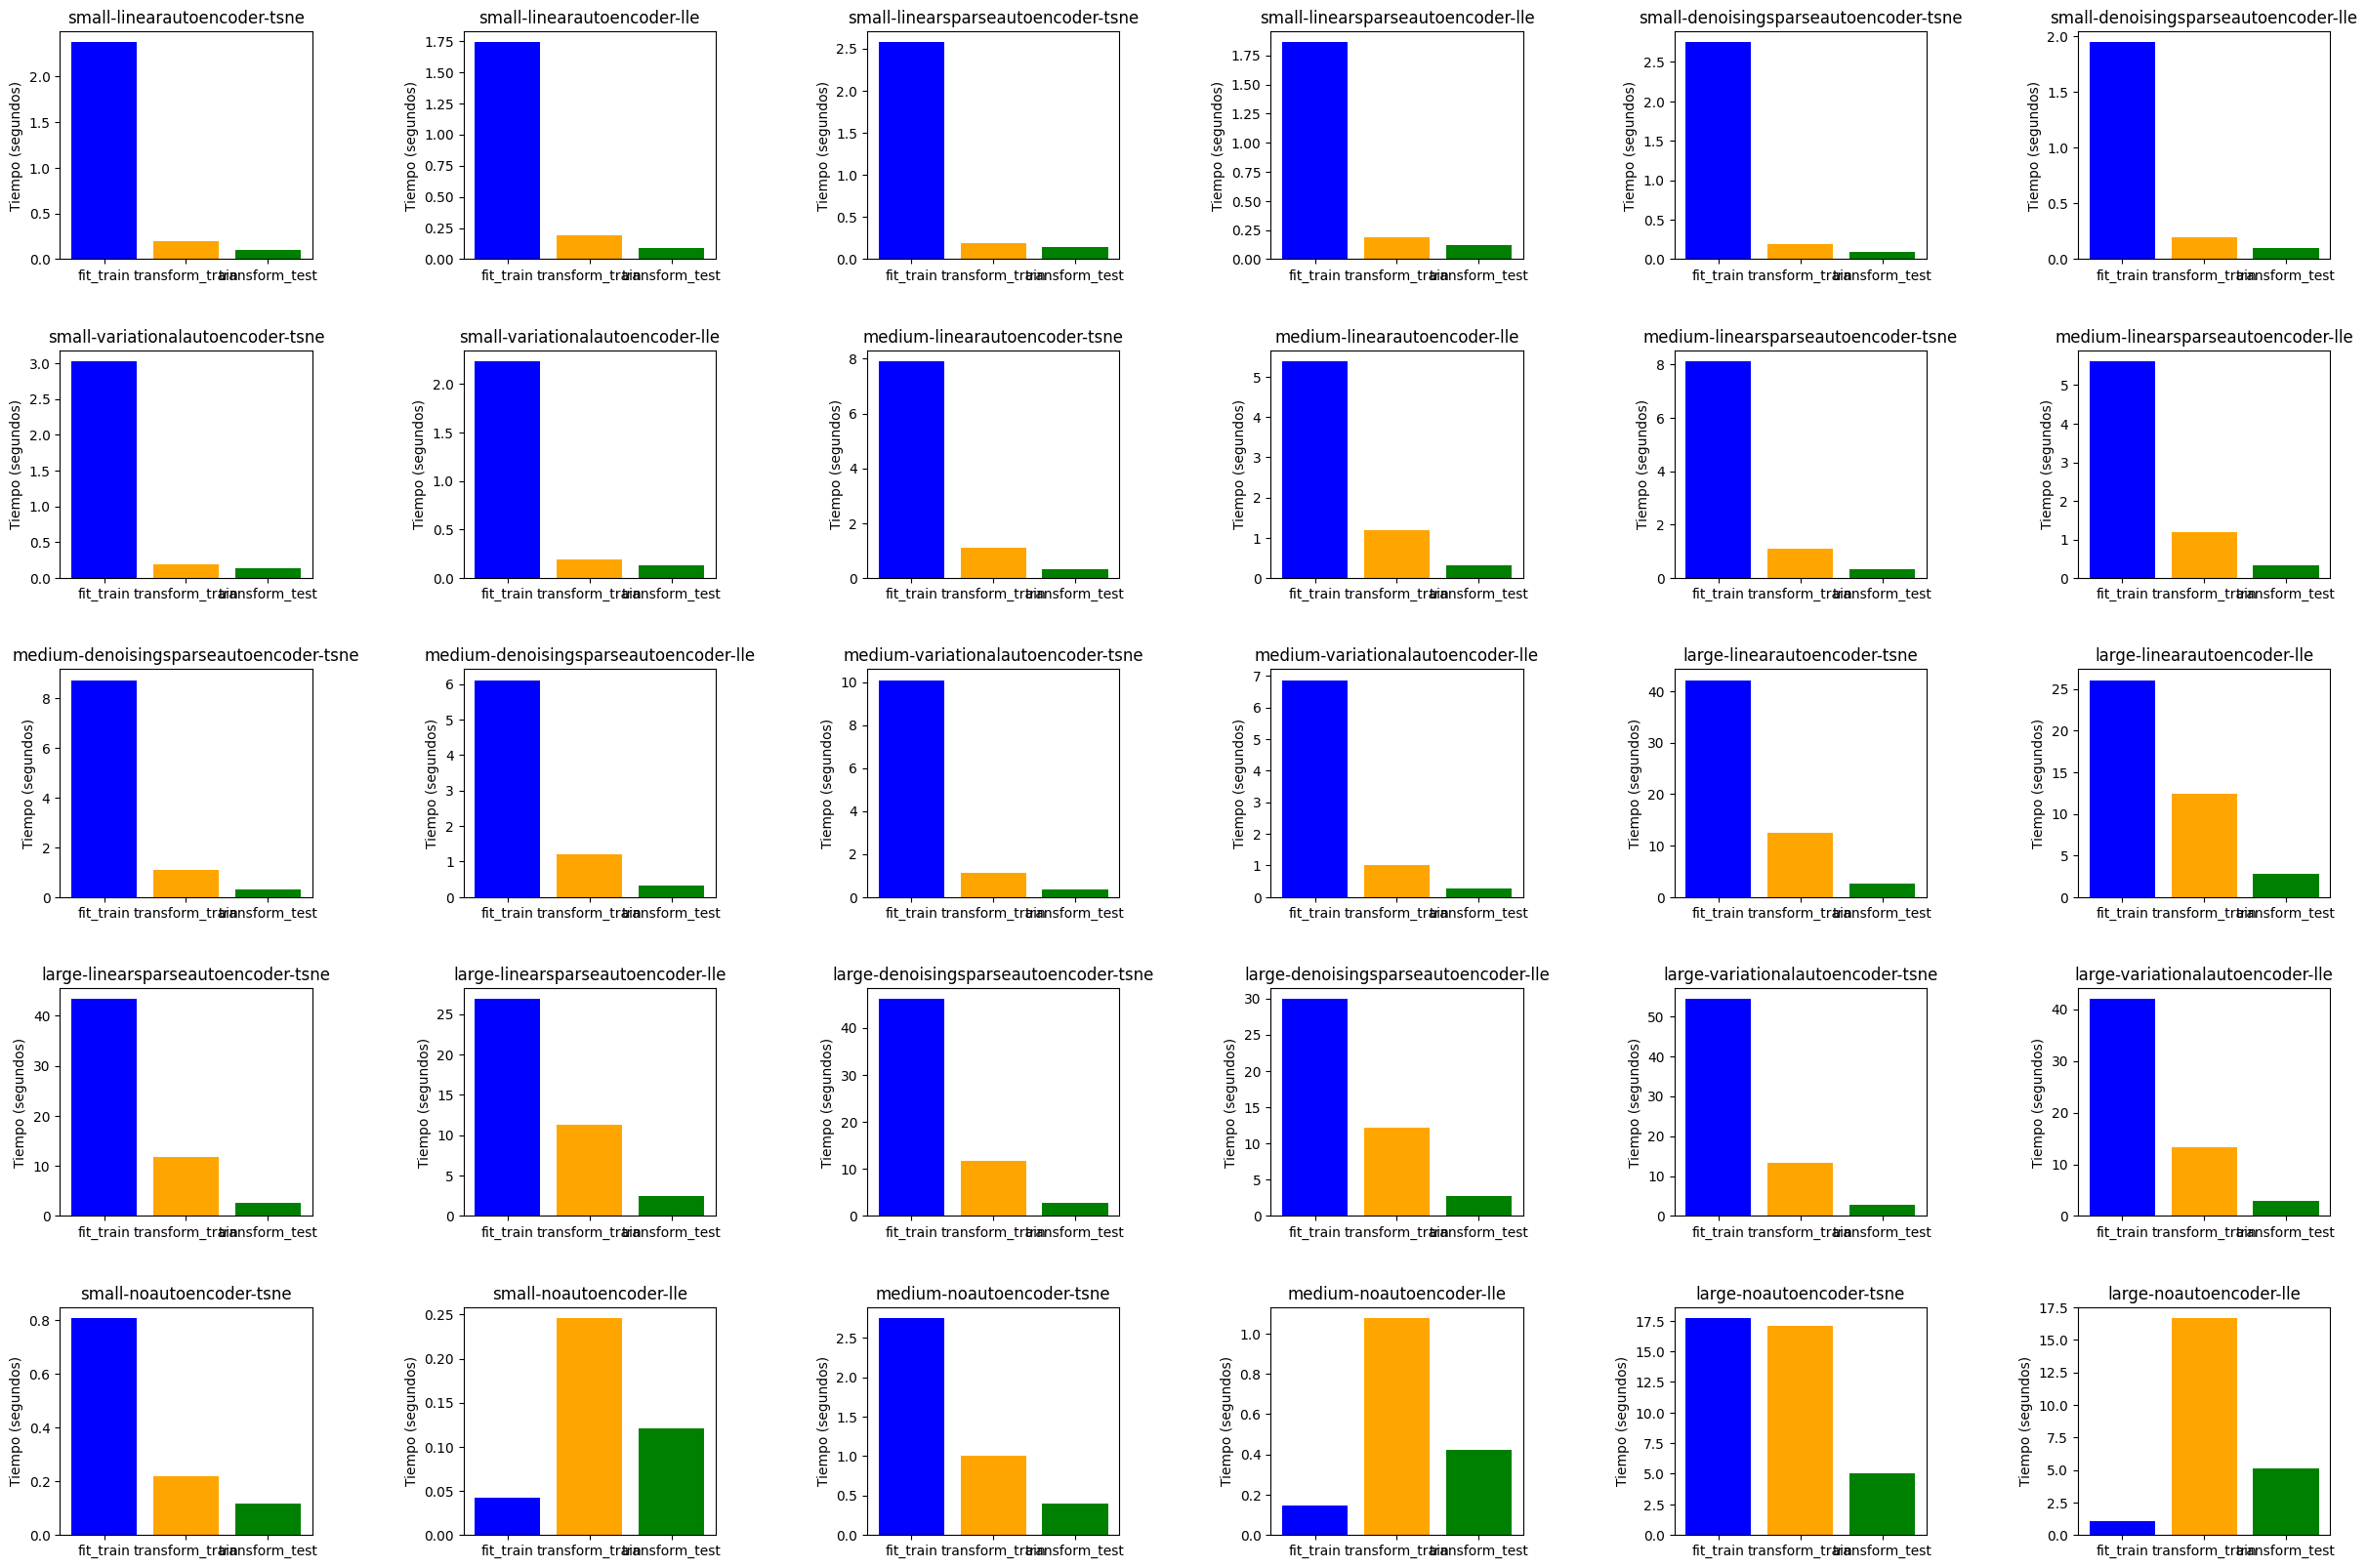

In [353]:
fmnist_timings = load_timings("Fashion-MNIST")
plot_timings(fmnist_timings, True, "fmnist_timings.png")

### Trustworthiness en Fashion MNIST
---

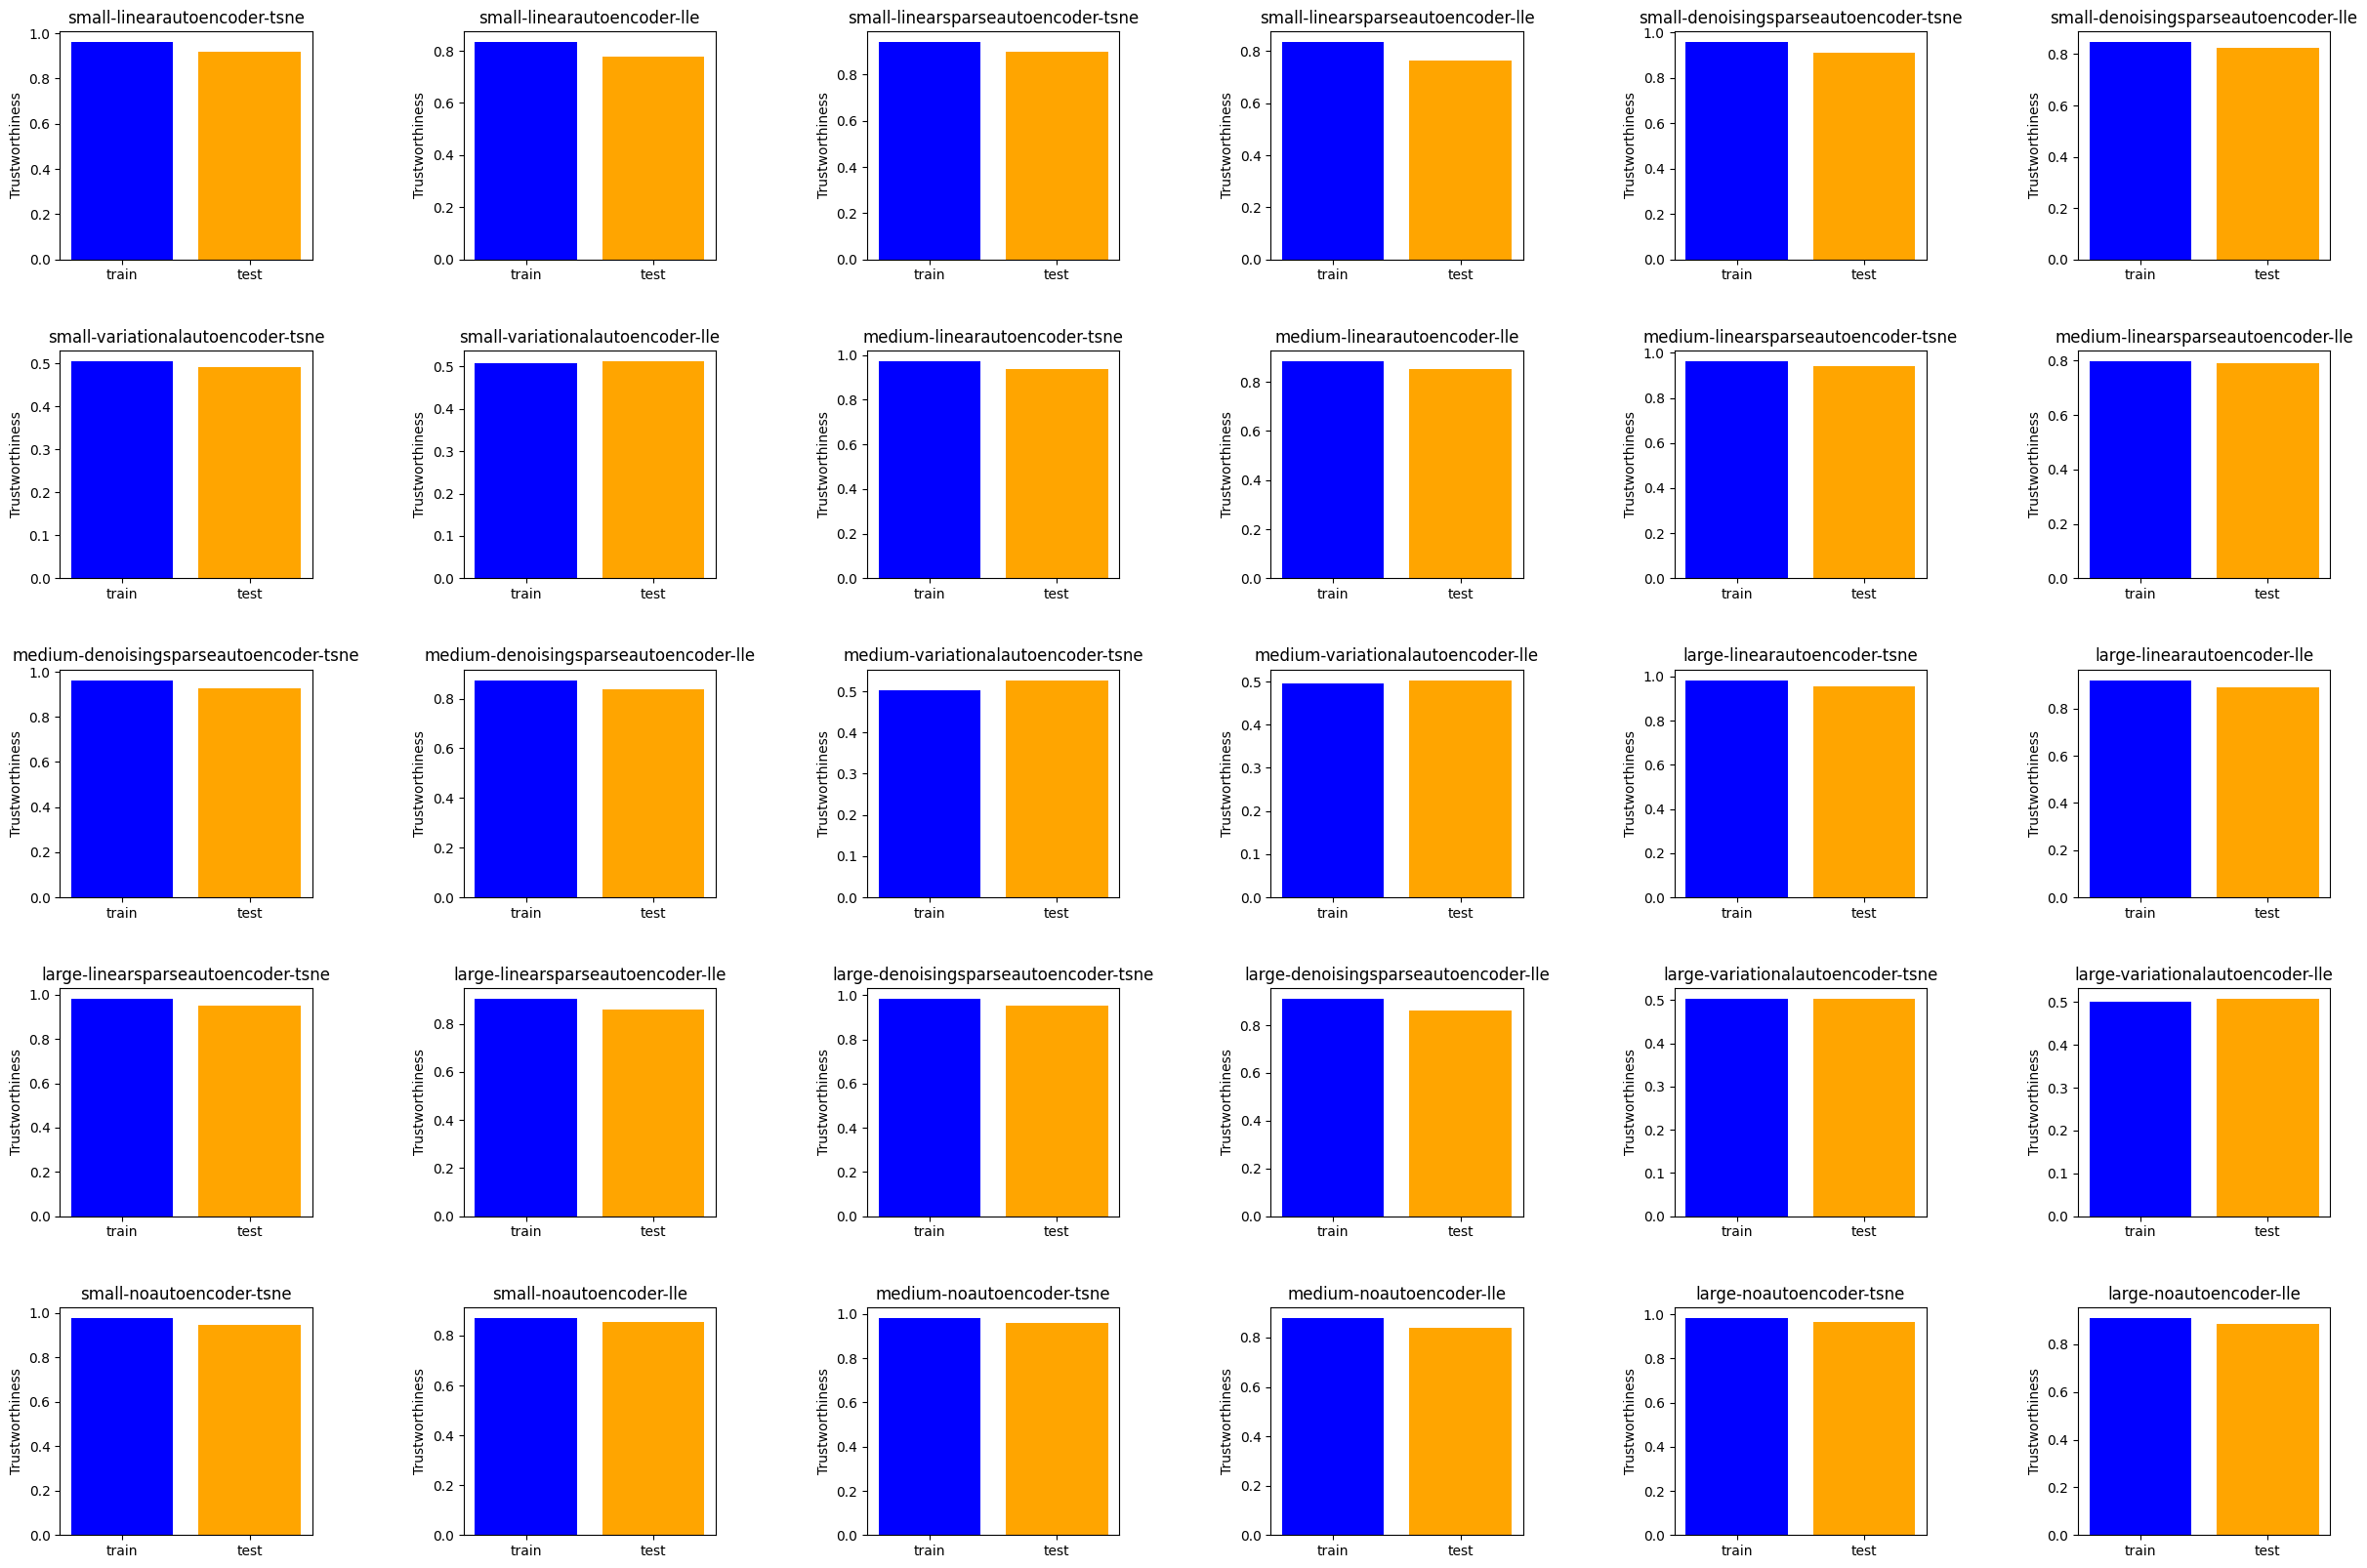

In [354]:
fmnist_trustworthiness = load_trustworthiness("Fashion-MNIST")
plot_trustworthiness(fmnist_trustworthiness, True, "fmnist_trustworthiness.png")

CIFAR-10
---
### Embeddings en CIFAR-10
---

In [355]:
cifar_embeddings = load_embeddings("Fashion-MNIST")
cifar_labels = load_labels("Fashion-MNIST")

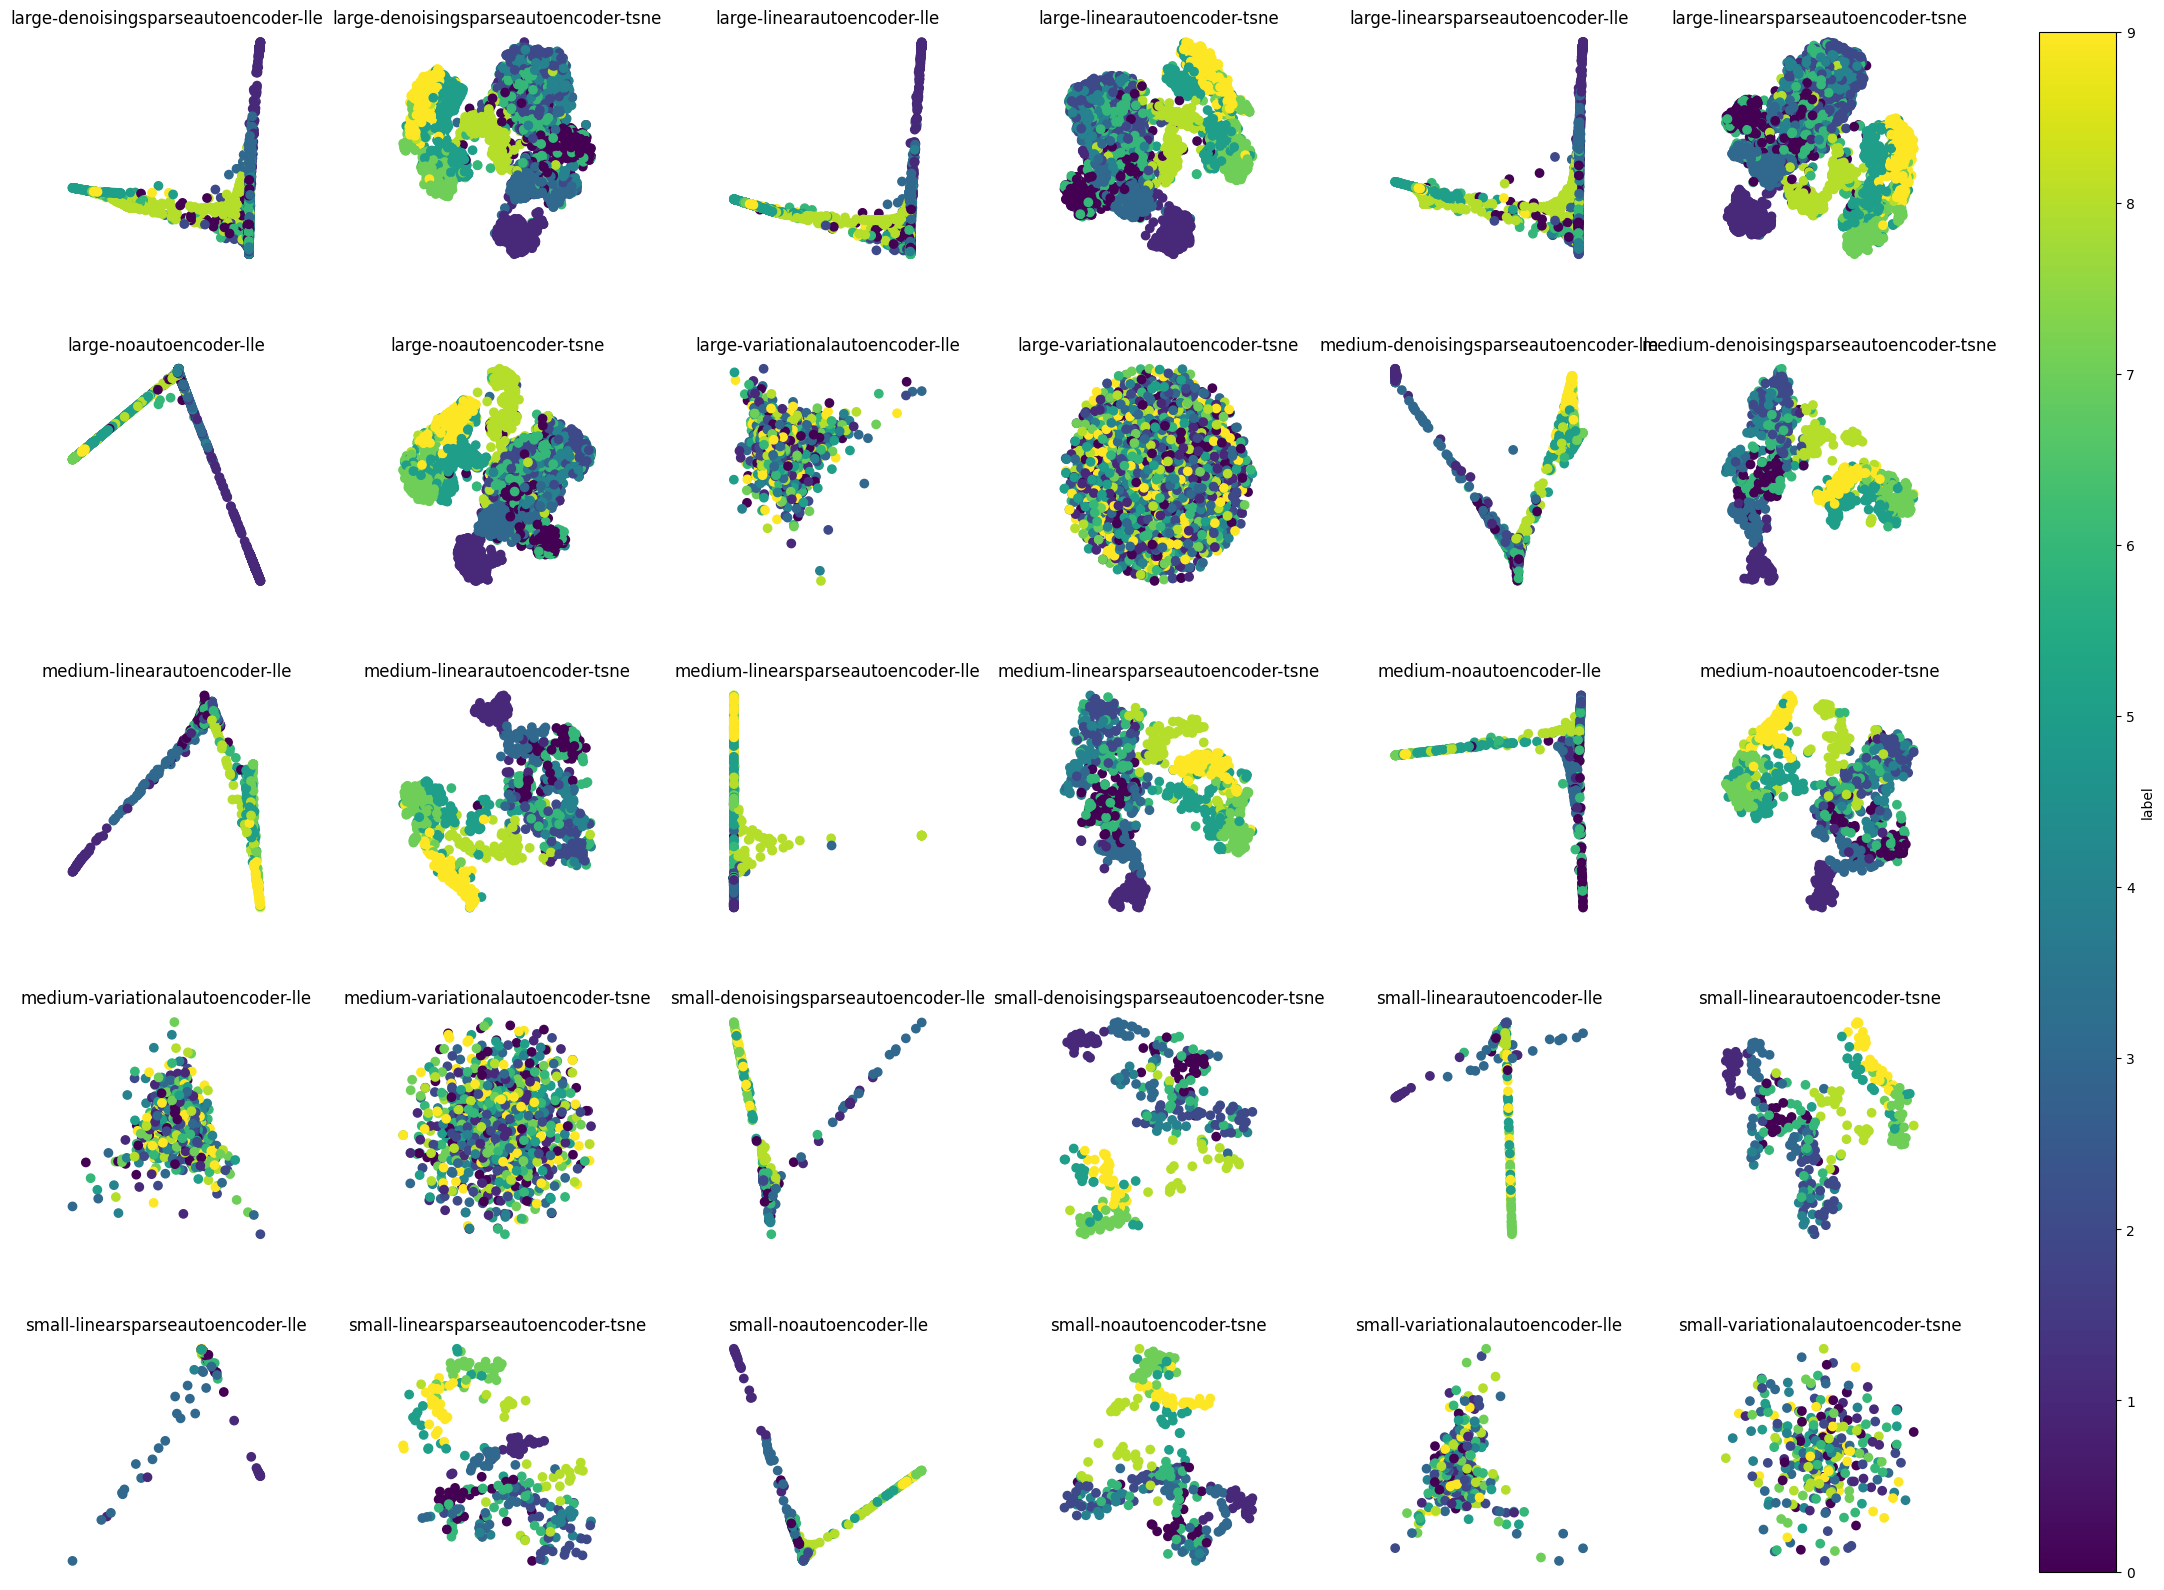

In [356]:
plot_embeddings(cifar_embeddings, cifar_labels, "train", True, "cifar_embeddings_train.png")

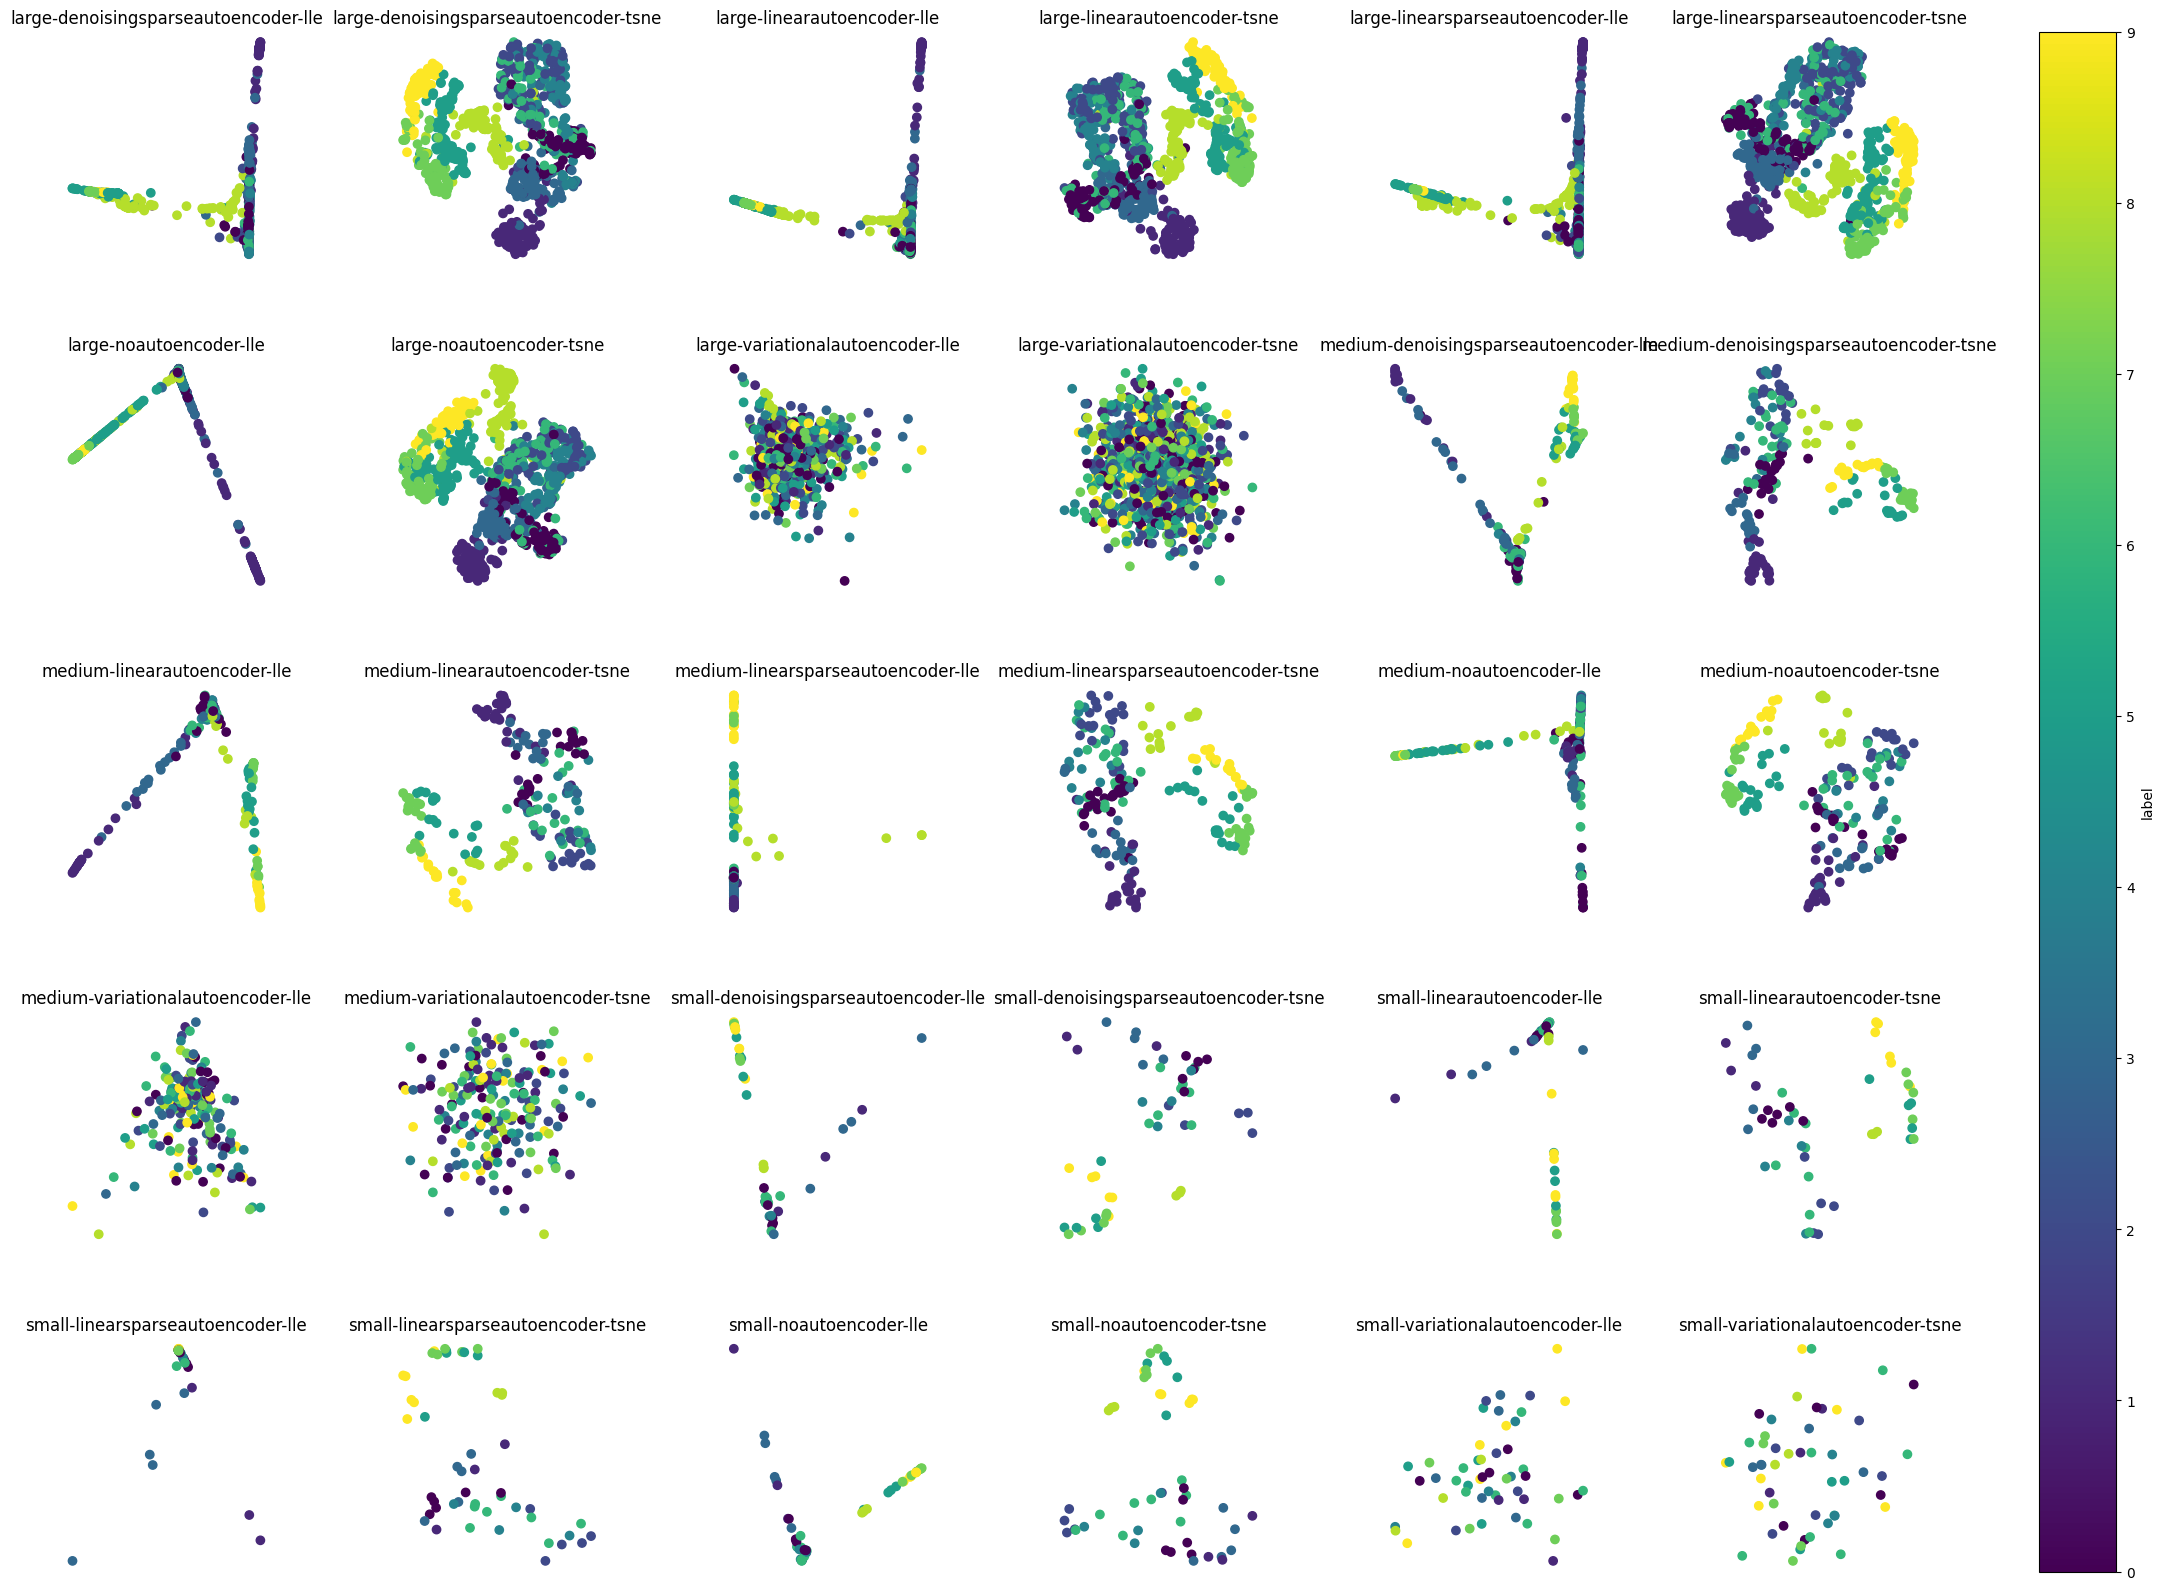

In [357]:
plot_embeddings(cifar_embeddings, cifar_labels, "test", True, "cifar_embeddings_test.png")

### Métricas temporales en CIFAR-10
---

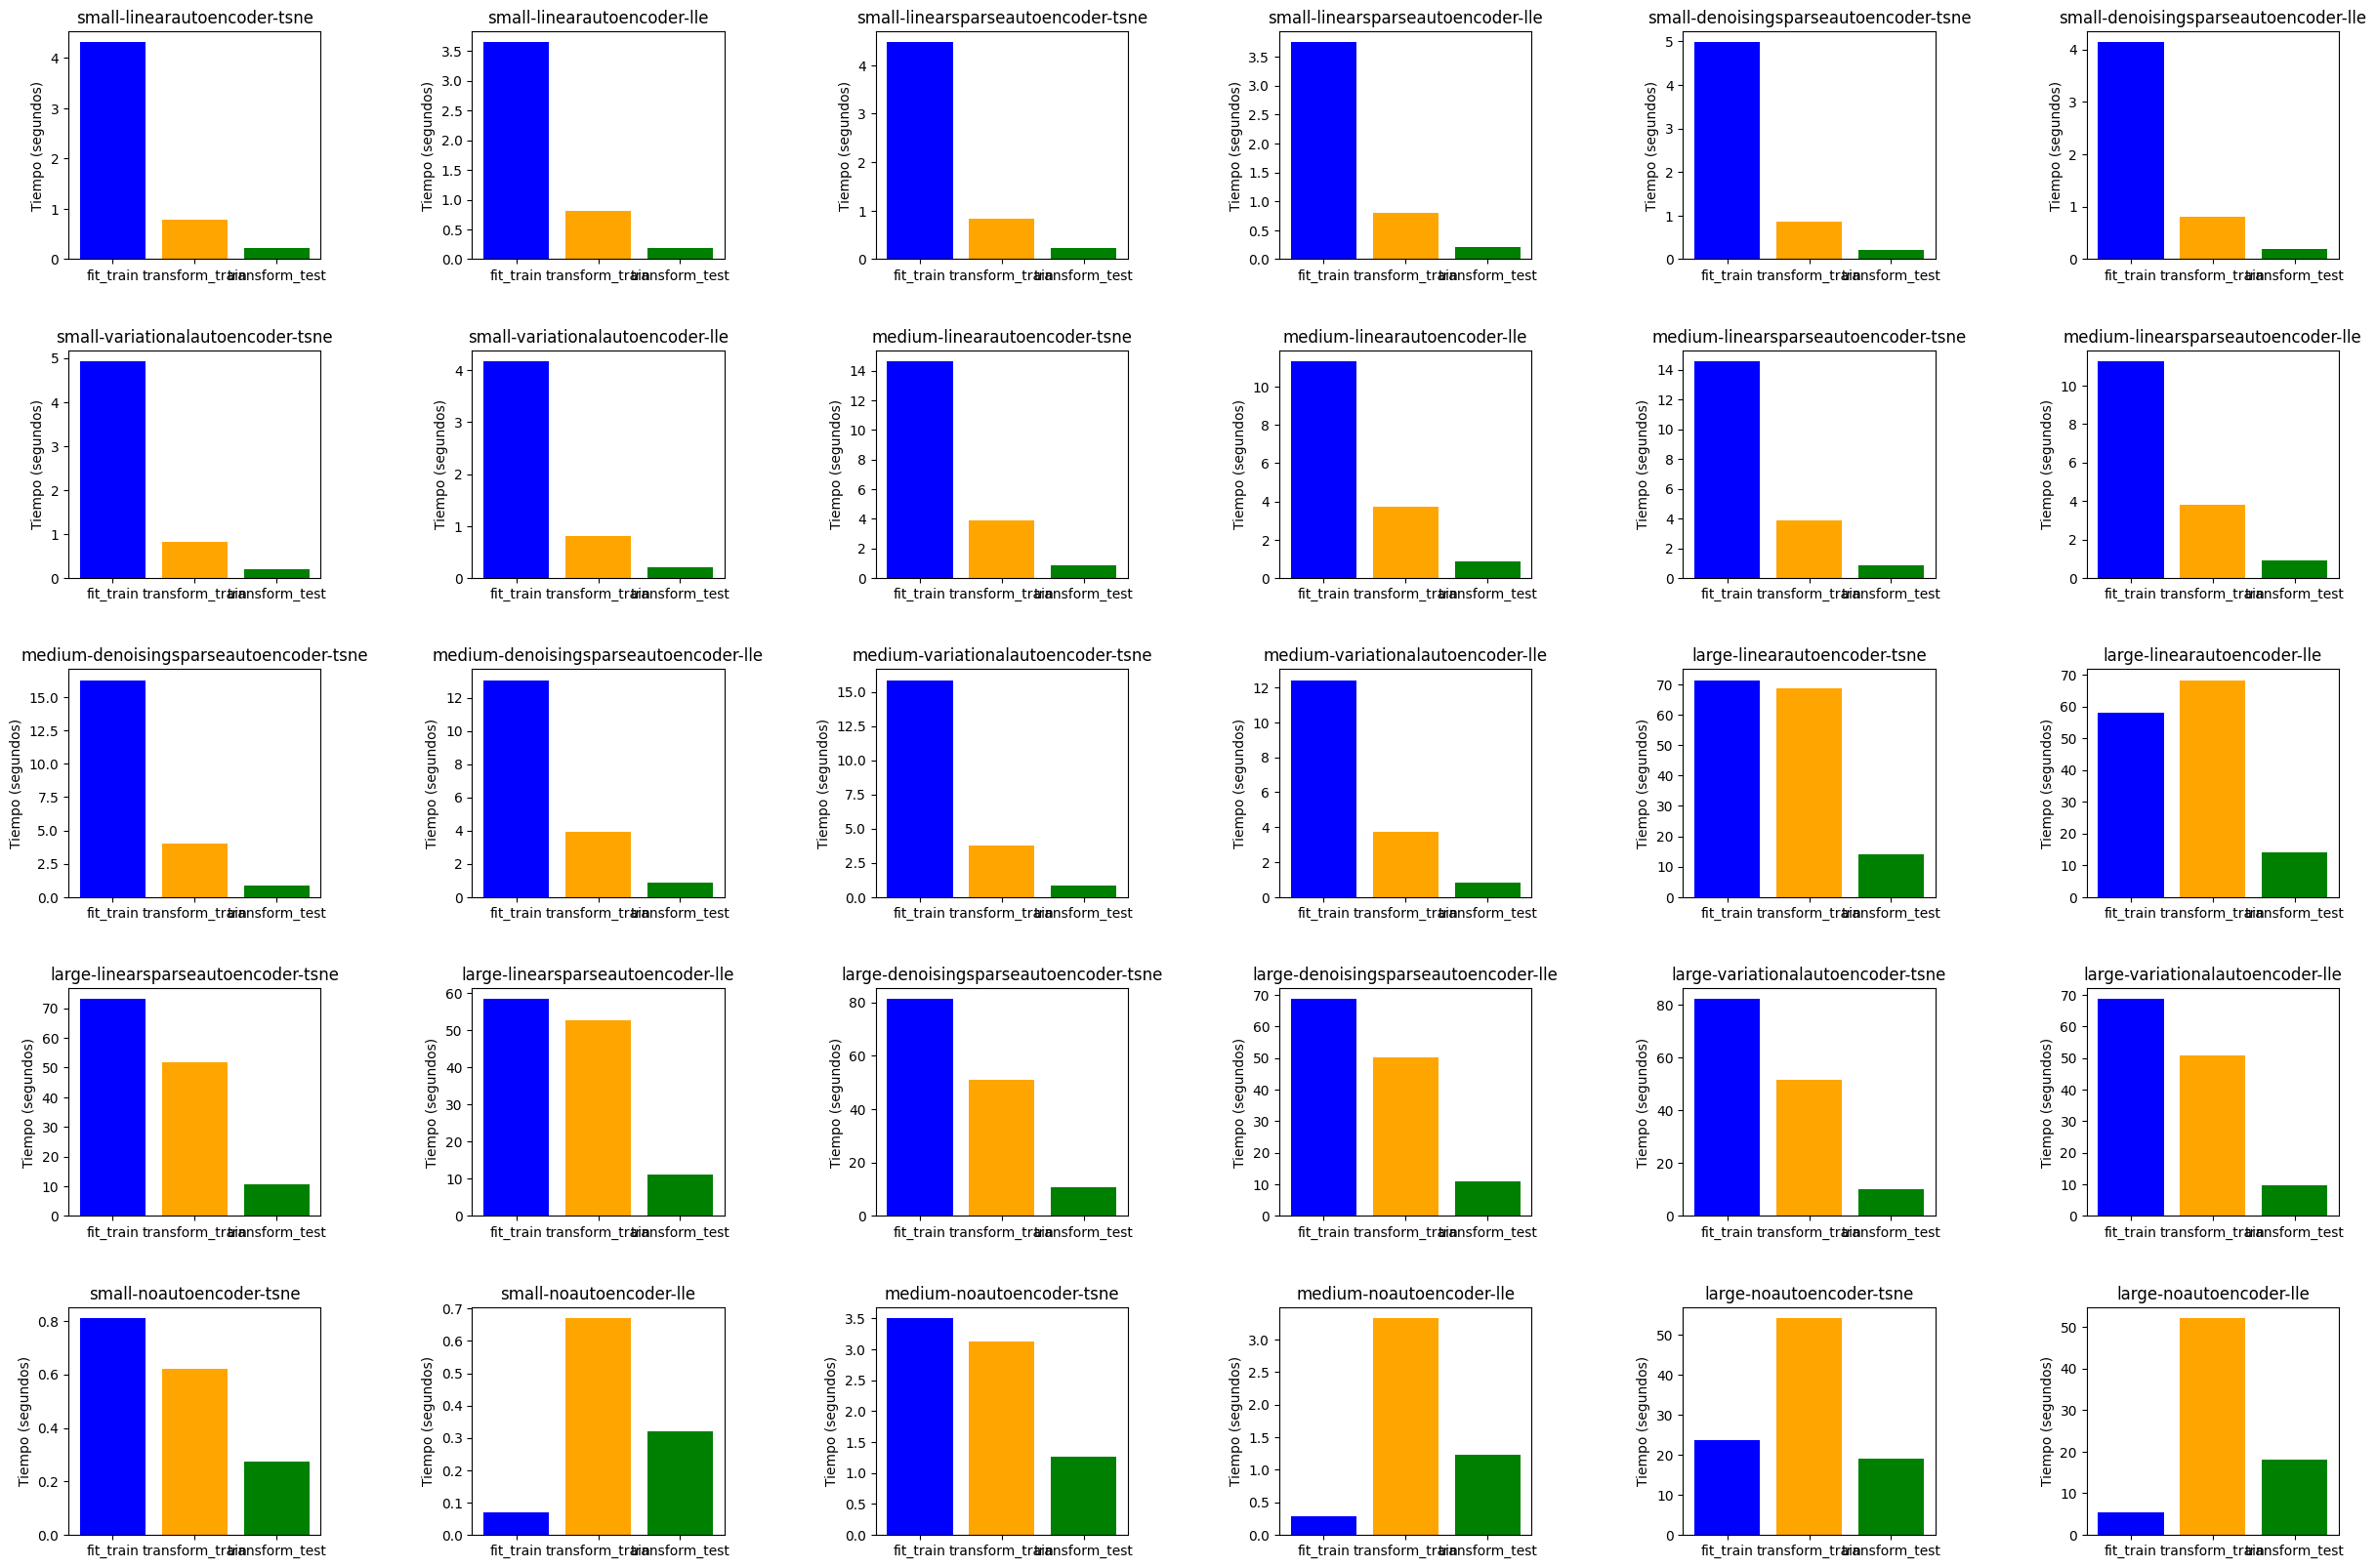

In [358]:
cifar_timings = load_timings("cifar_10_small")
plot_timings(cifar_timings, True, "cifar_timings.png")

### Trustworthiness en CIFAR-10
---

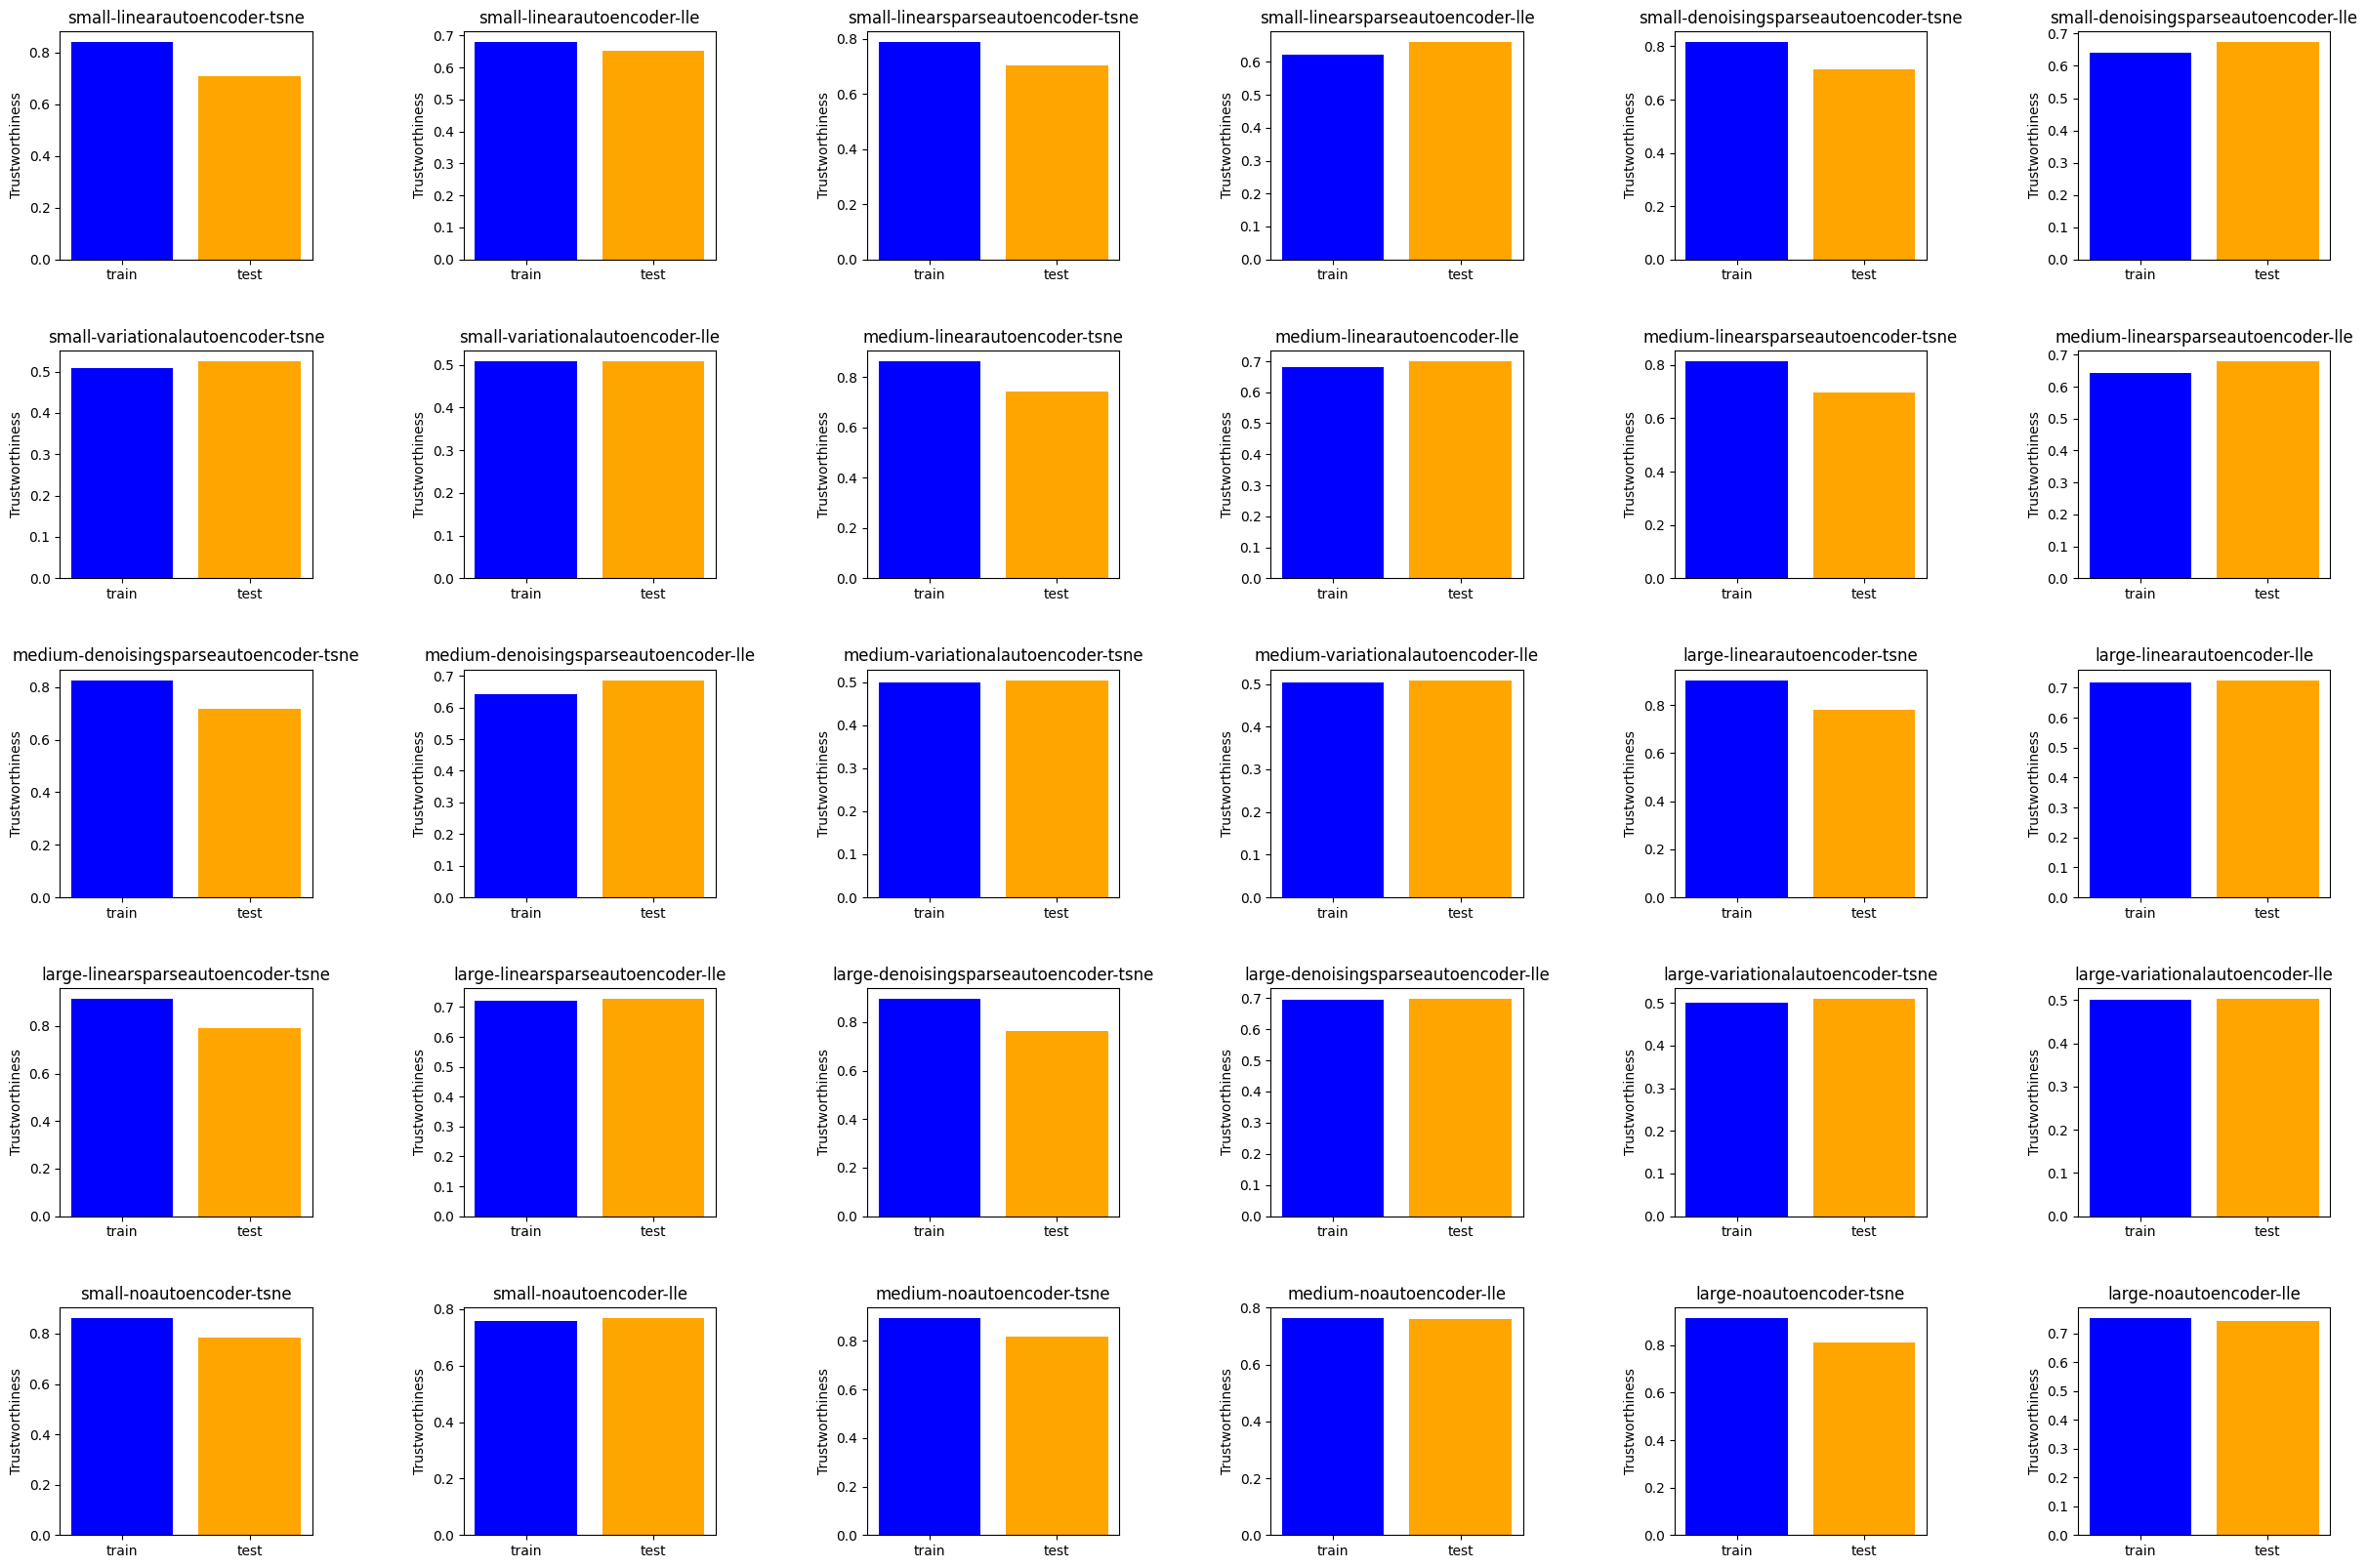

In [359]:
cifar_trustworthiness = load_trustworthiness("cifar_10_small")
plot_trustworthiness(cifar_trustworthiness, True, "cifar_trustworthiness.png")

Glass Identification
---
### Embeddings en Glass Identification
---

In [360]:
glass_embeddings = load_embeddings("Fashion-MNIST")
glass_labels = load_labels("Fashion-MNIST")

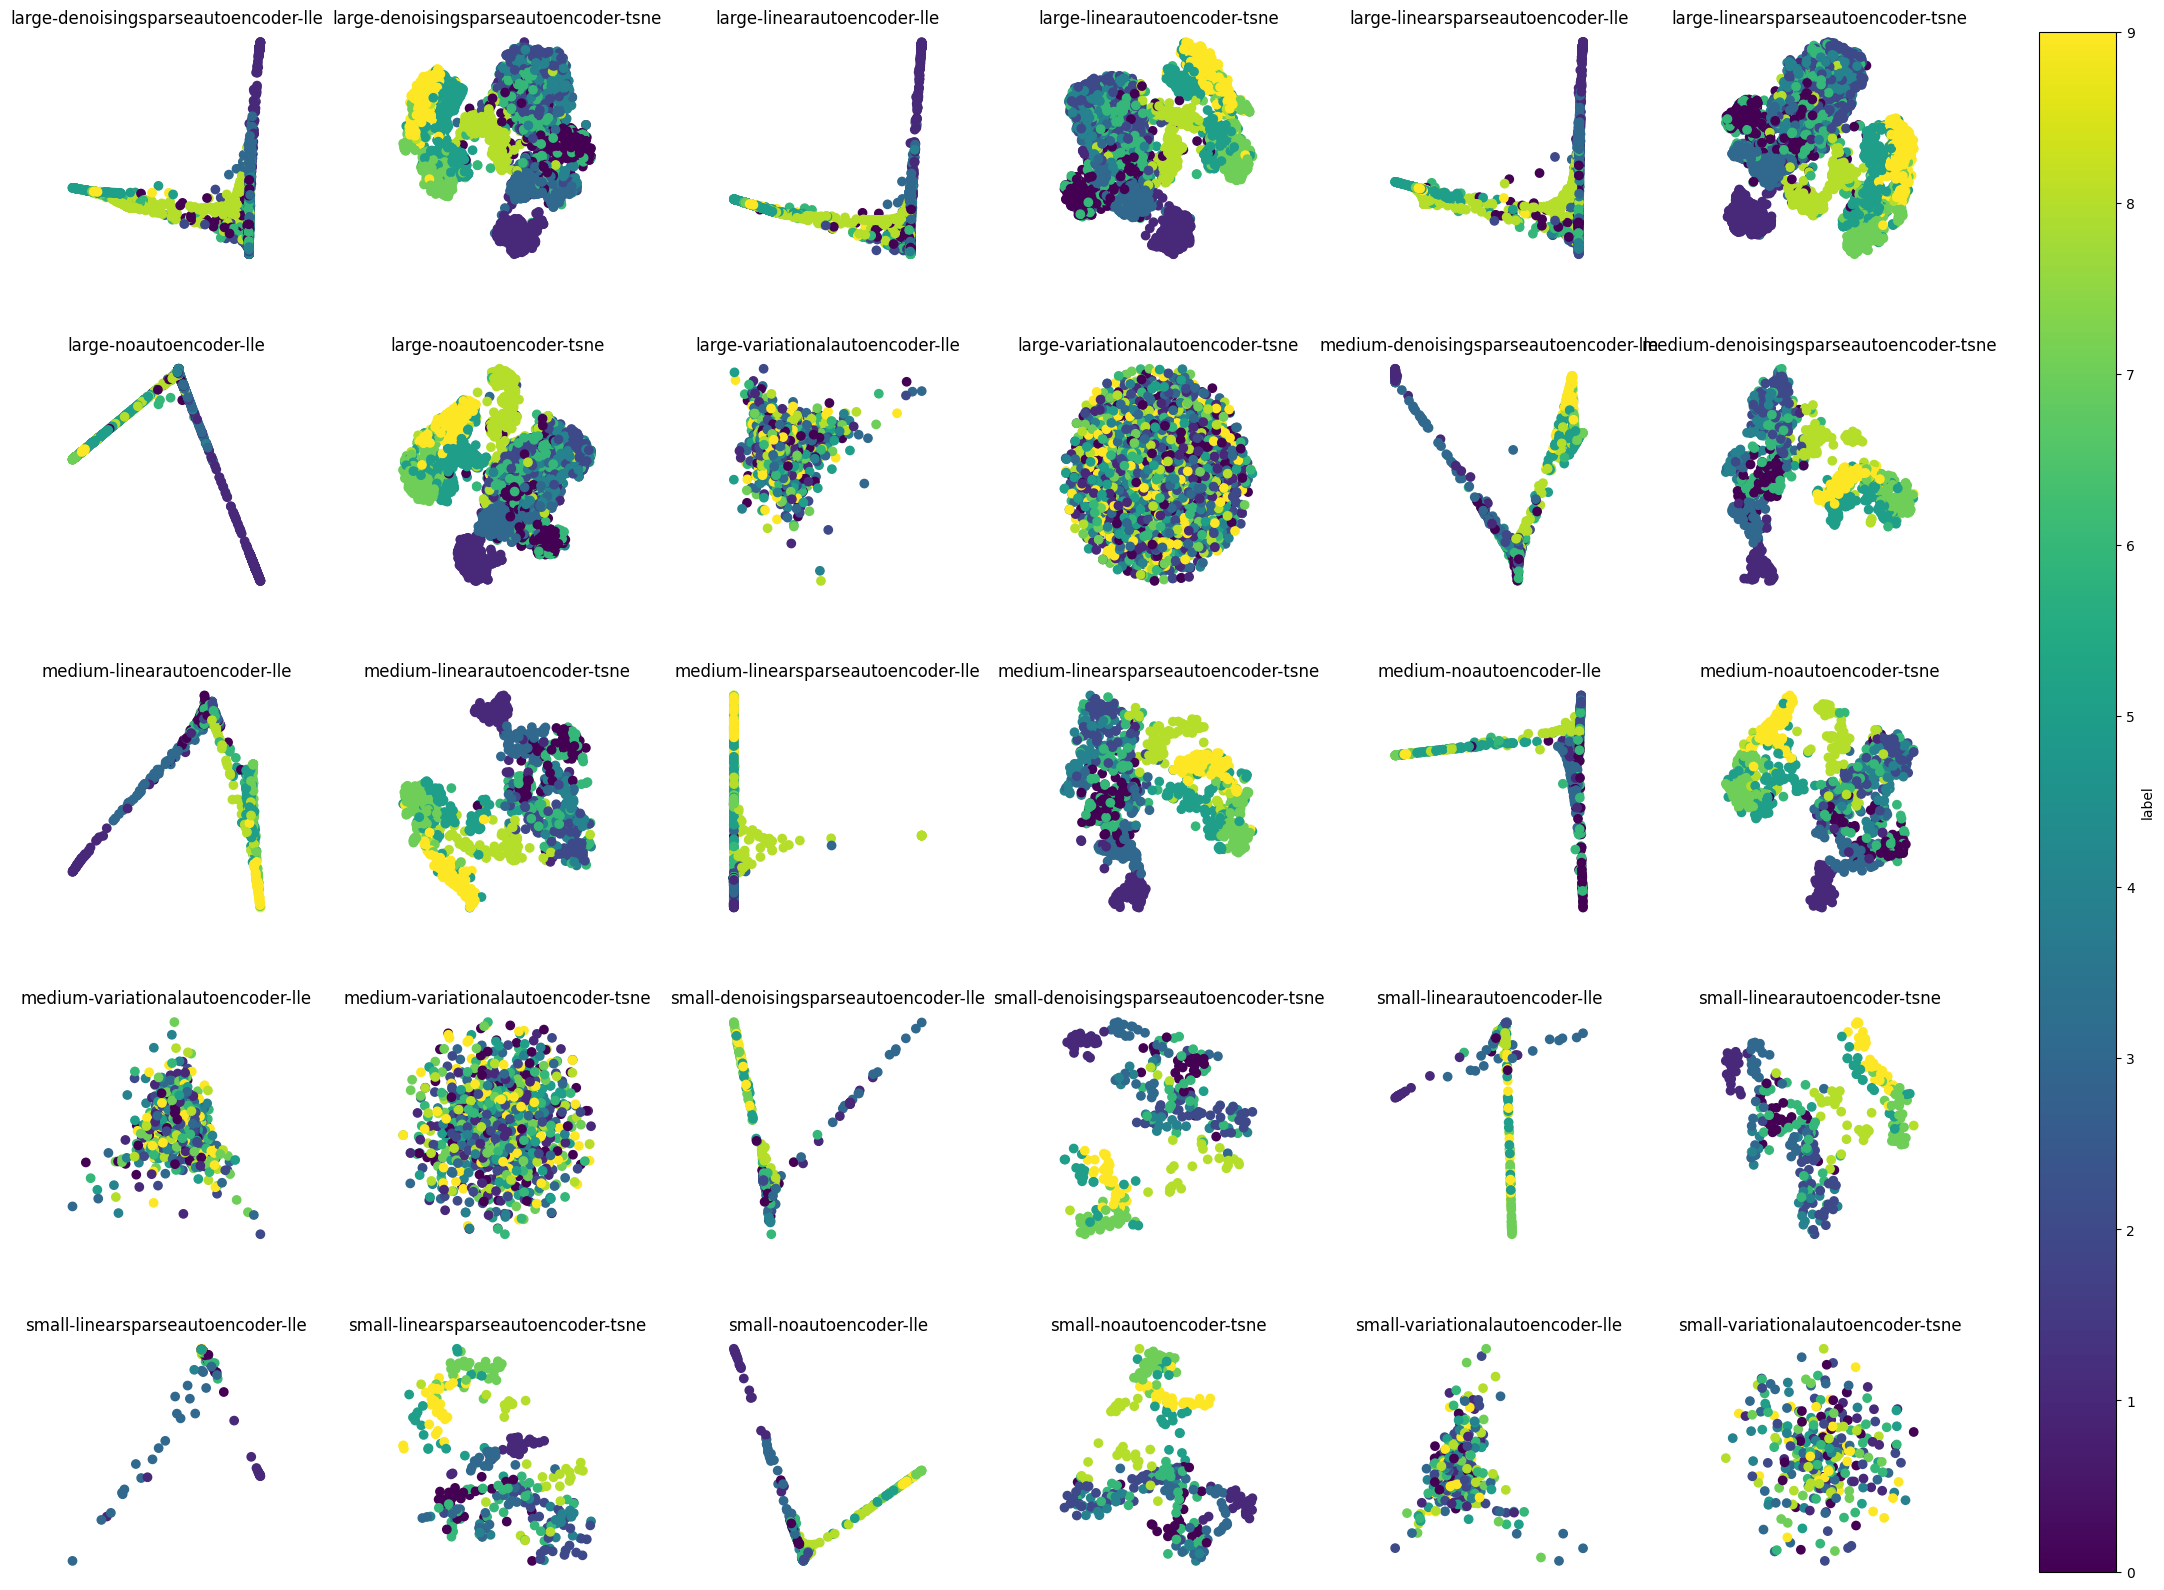

In [361]:
plot_embeddings(glass_embeddings, glass_labels, "train", True, "glass_embeddings_train.png")

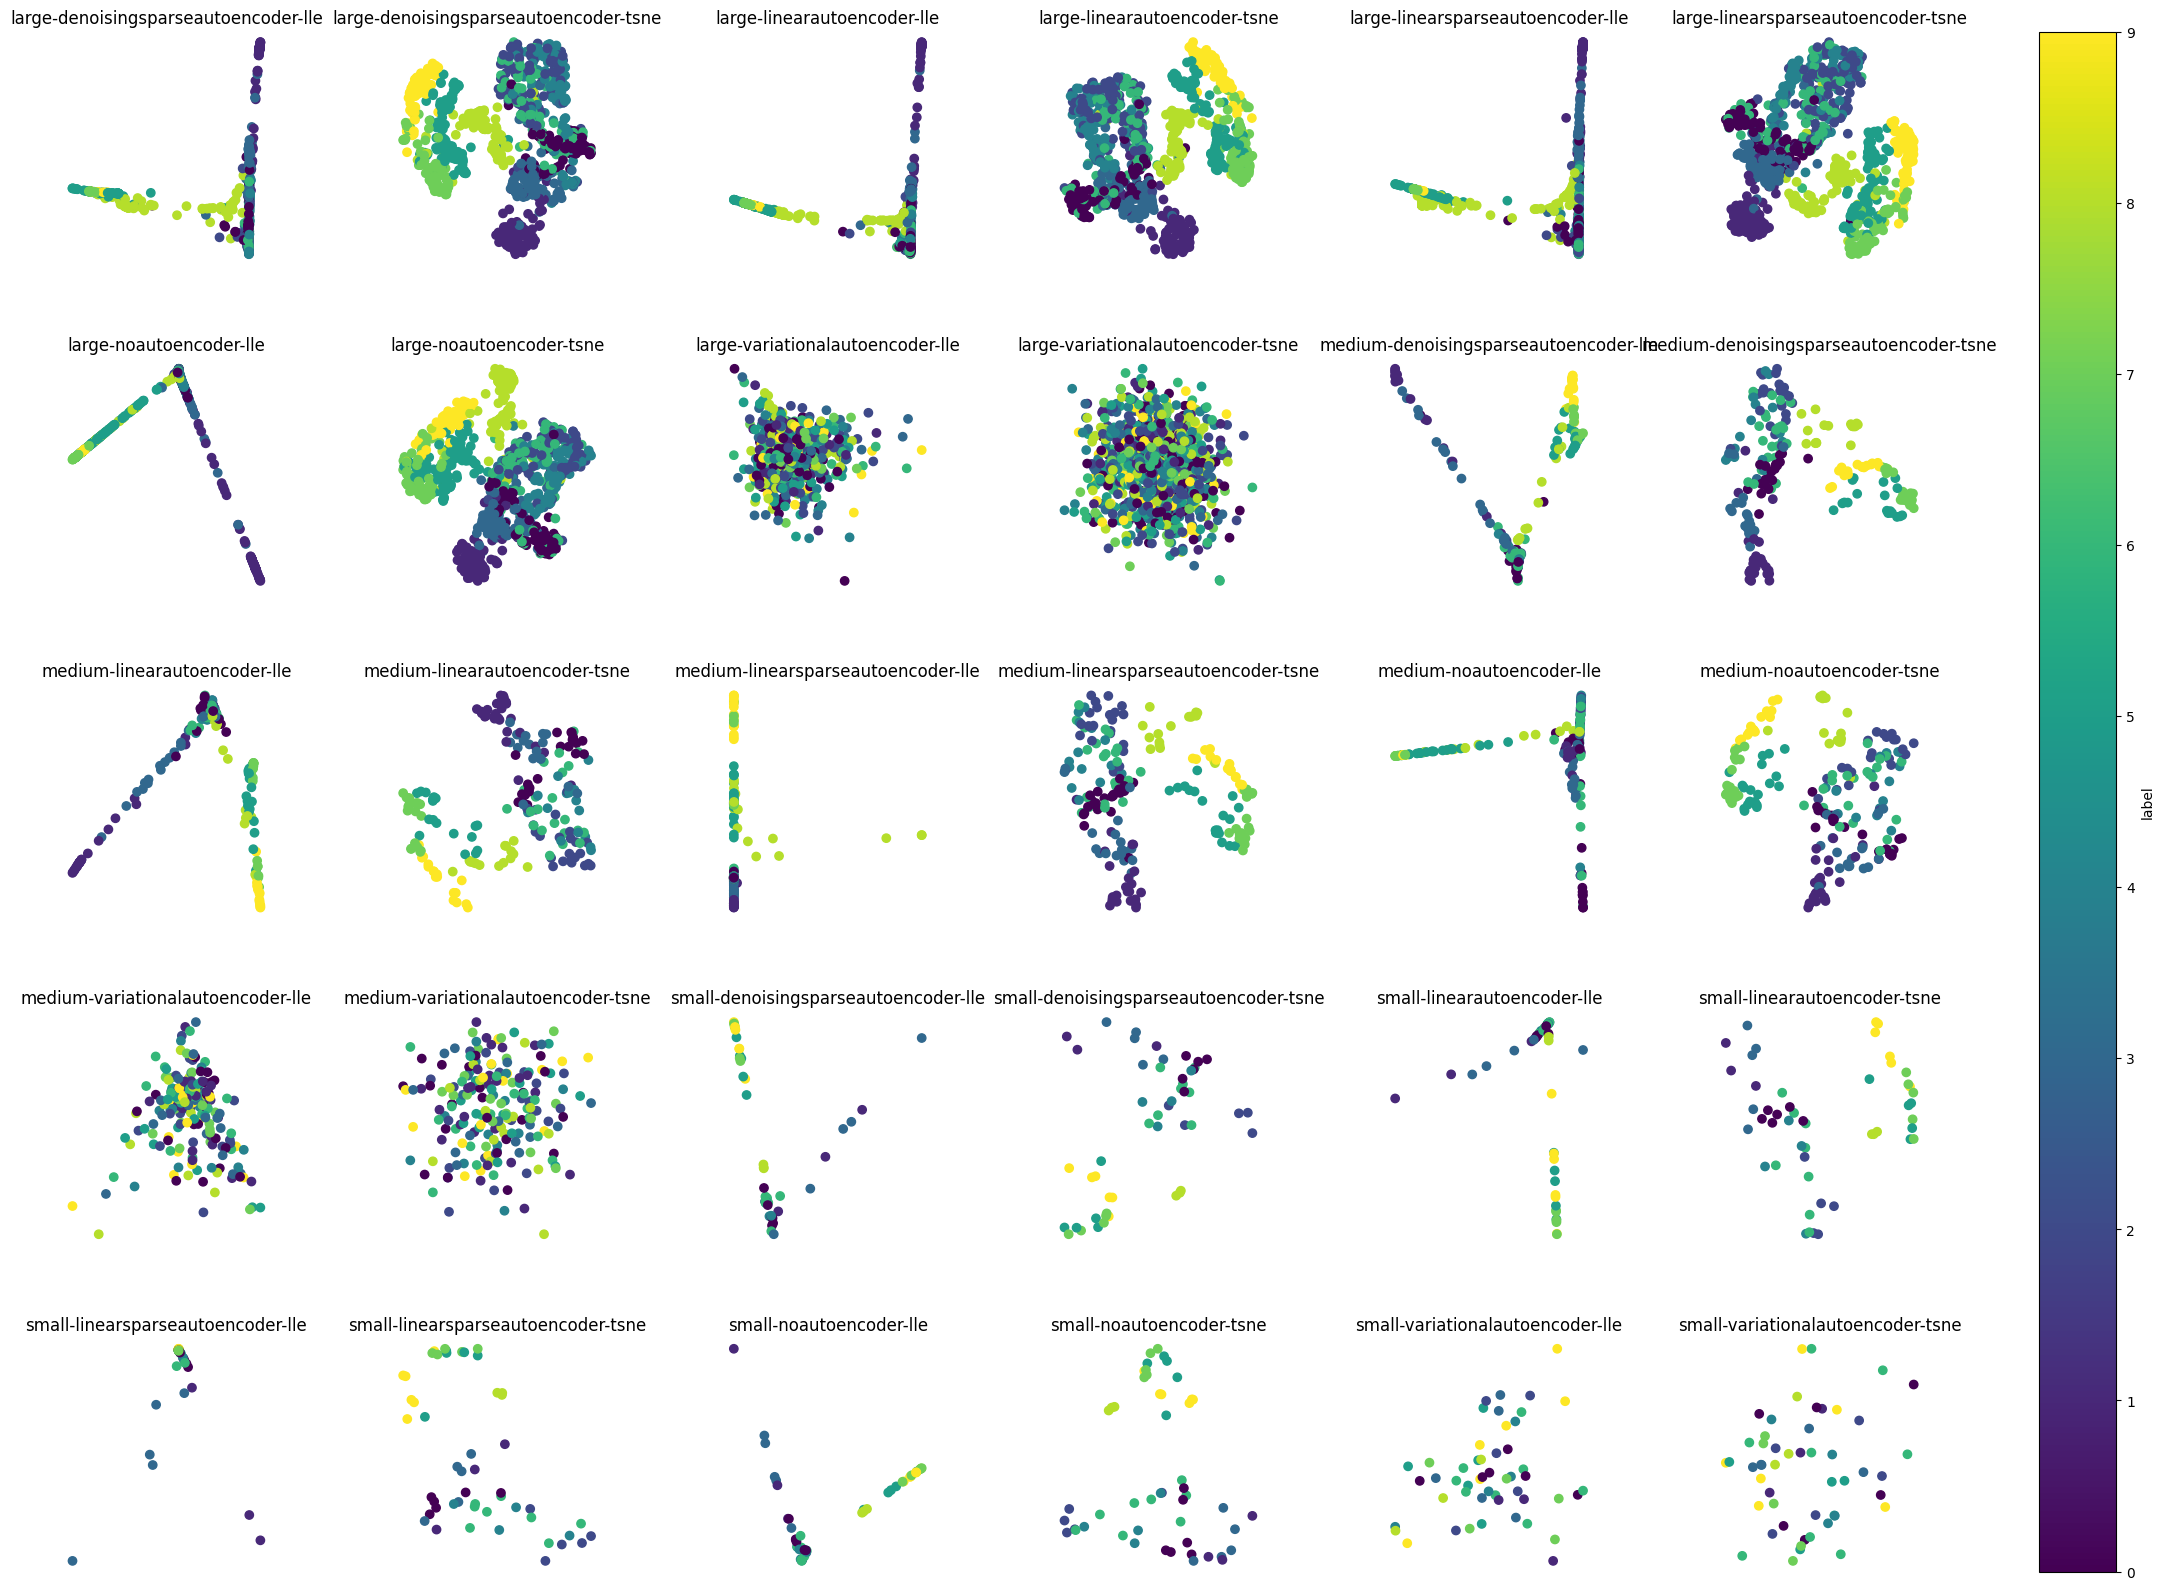

In [362]:
plot_embeddings(glass_embeddings, glass_labels, "test", True, "glass_embeddings_test.png")

### Métricas temporales en Glass Identification
---

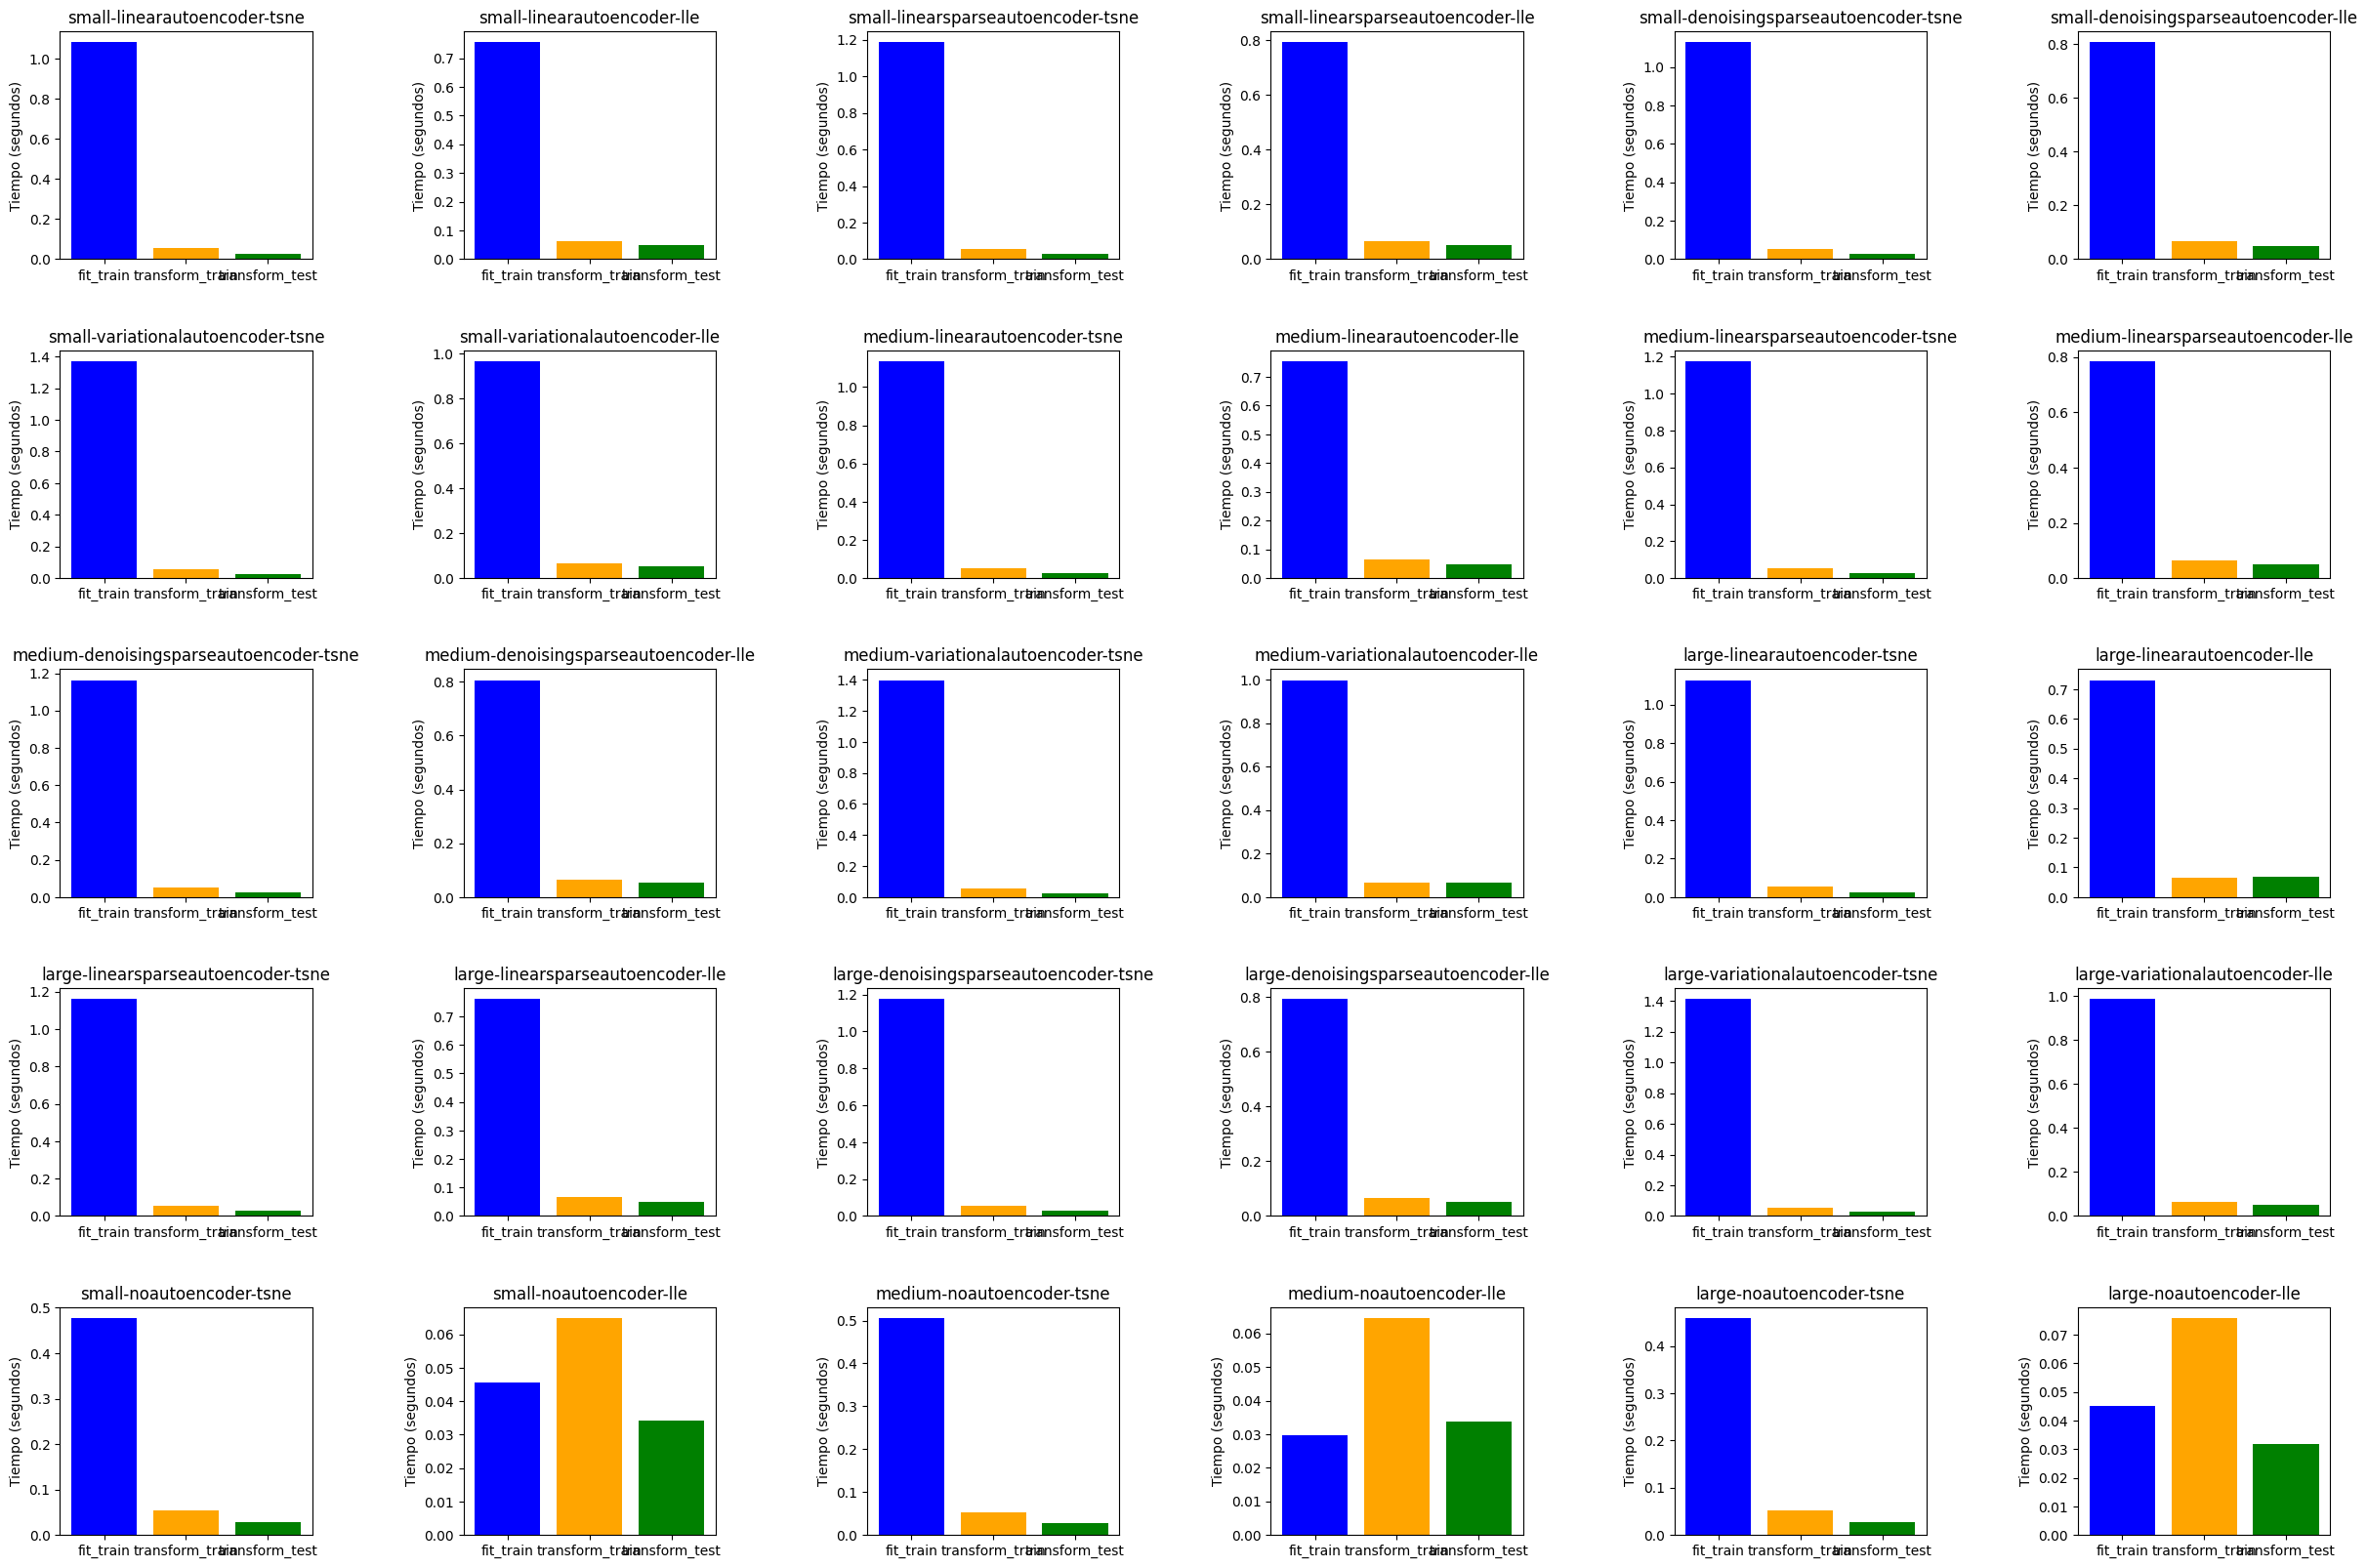

In [363]:
glass_timings = load_timings("Glass-Classification")
plot_timings(glass_timings, True, "glass_timings.png")

### Trustworthiness en Glass Identification
---

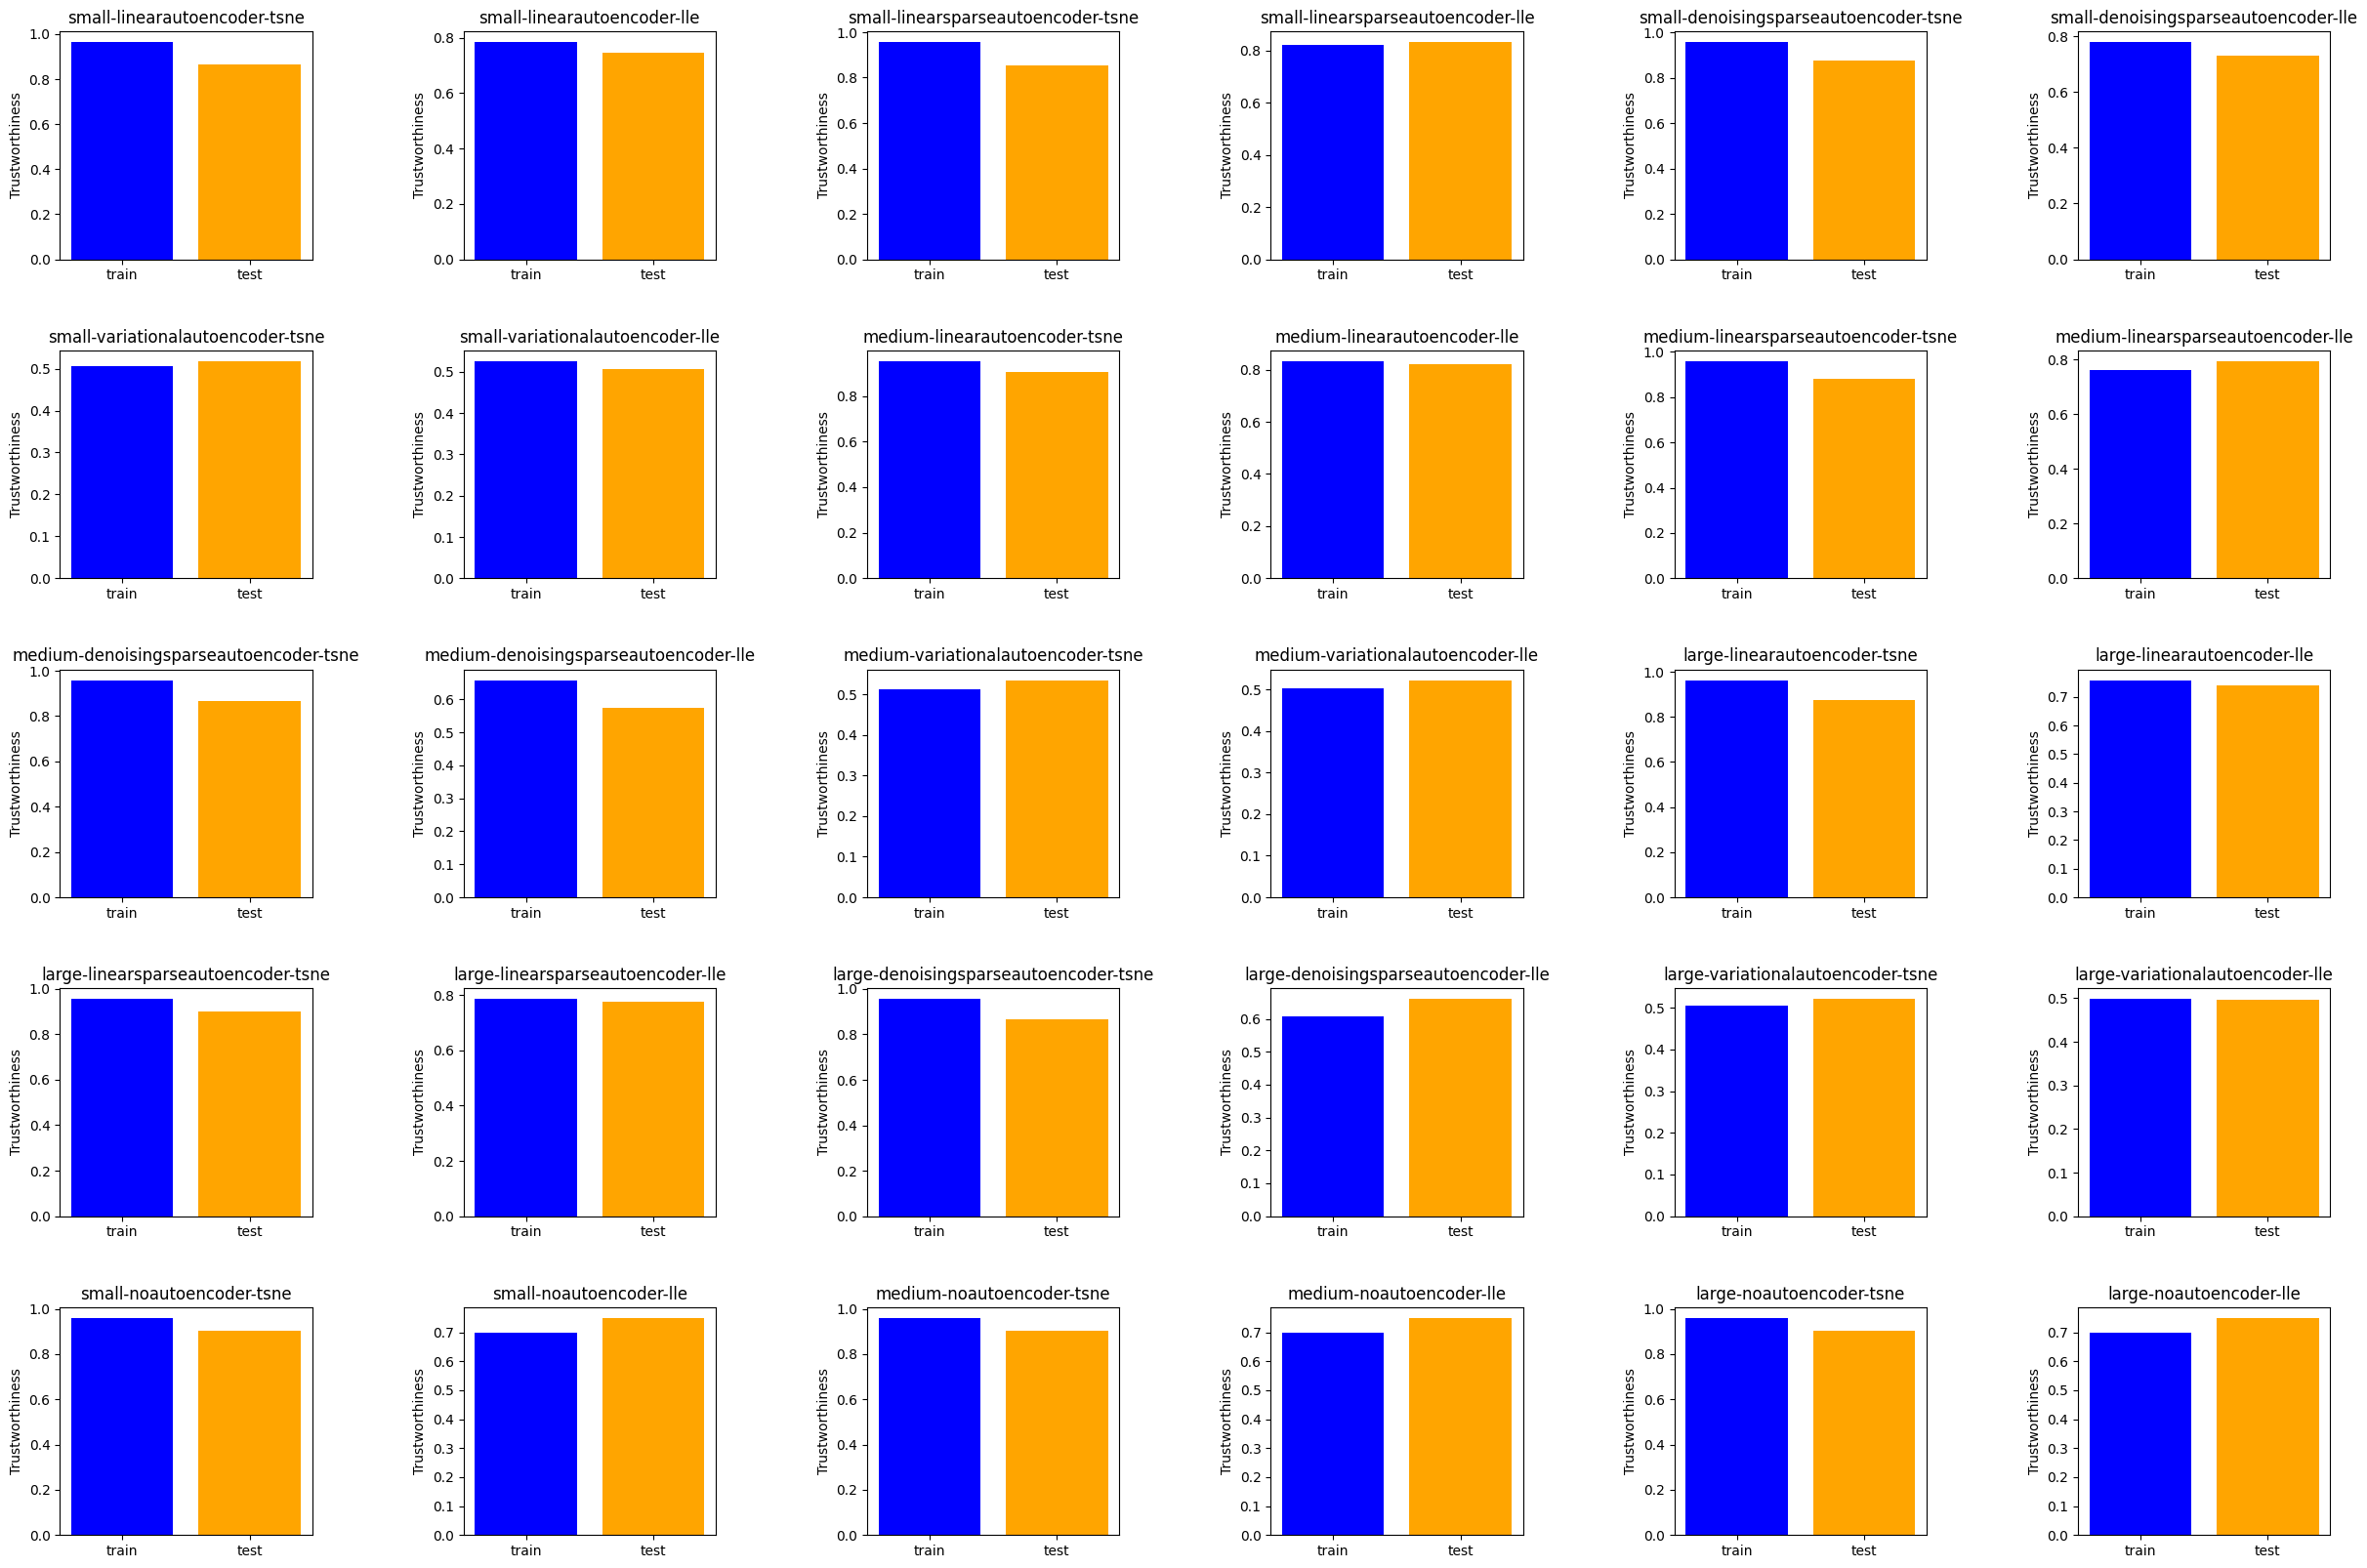

In [364]:
glass_trustworthiness = load_trustworthiness("Glass-Classification")
plot_trustworthiness(glass_trustworthiness, True, "glass_trustworthiness.png")